In [18]:
import re


filename = "decor-k1e-04,1e+00,0e+00.pt"

match = re.search(r'(?:decor|cor)-([^\.,]+),([^\.,]+),([^\.,]+)\.pt', filename)
lr, val2, val3 = match.groups()
prefix_match = re.match(r'^([a-zA-Z]+)', lr)
prefix = prefix_match.group(1)
lr = re.sub(r'^[a-zA-Z]+', '', lr)
print(float(lr), float(val2), float(val3))
print(prefix)



0.0001 1.0 0.0
k


Processing: ./results EG 4680 bias/1
Processing: ./results EG 4680 bias/22
Processing: ./results EG 4680 bias/42
All files processed.
####################CONSISTENCY CHECK###################:  True
acc reg:  [{'dataset': 'reg', 'type': 'decor', 'val_loss': 0.09112641019222596, 'learning_rate': ' 1e-03', 'decor_learning_rate': ' 1e-08', 'val_accuracy': 0.9819999999999999, 'decay': 0.0, 'totalLoss': 0.08724266932447317}]
loss reg:  [{'dataset': 'reg', 'type': 'decor', 'val_loss': 0.09112641019222596, 'learning_rate': ' 1e-03', 'decor_learning_rate': ' 1e-08', 'val_accuracy': 0.9819999999999999, 'decay': 0.0, 'totalLoss': 0.08724266932447317}]
total loss reg [{'dataset': 'reg', 'type': 'decor', 'val_loss': 0.09112641019222596, 'learning_rate': ' 1e-03', 'decor_learning_rate': ' 1e-08', 'val_accuracy': 0.9819999999999999, 'decay': 0.0, 'totalLoss': 0.08724266932447317}]
acc k:  [{'dataset': 'k', 'type': 'decor', 'val_loss': 0.21154523879007728, 'learning_rate': ' 1e-03', 'decor_learning_ra

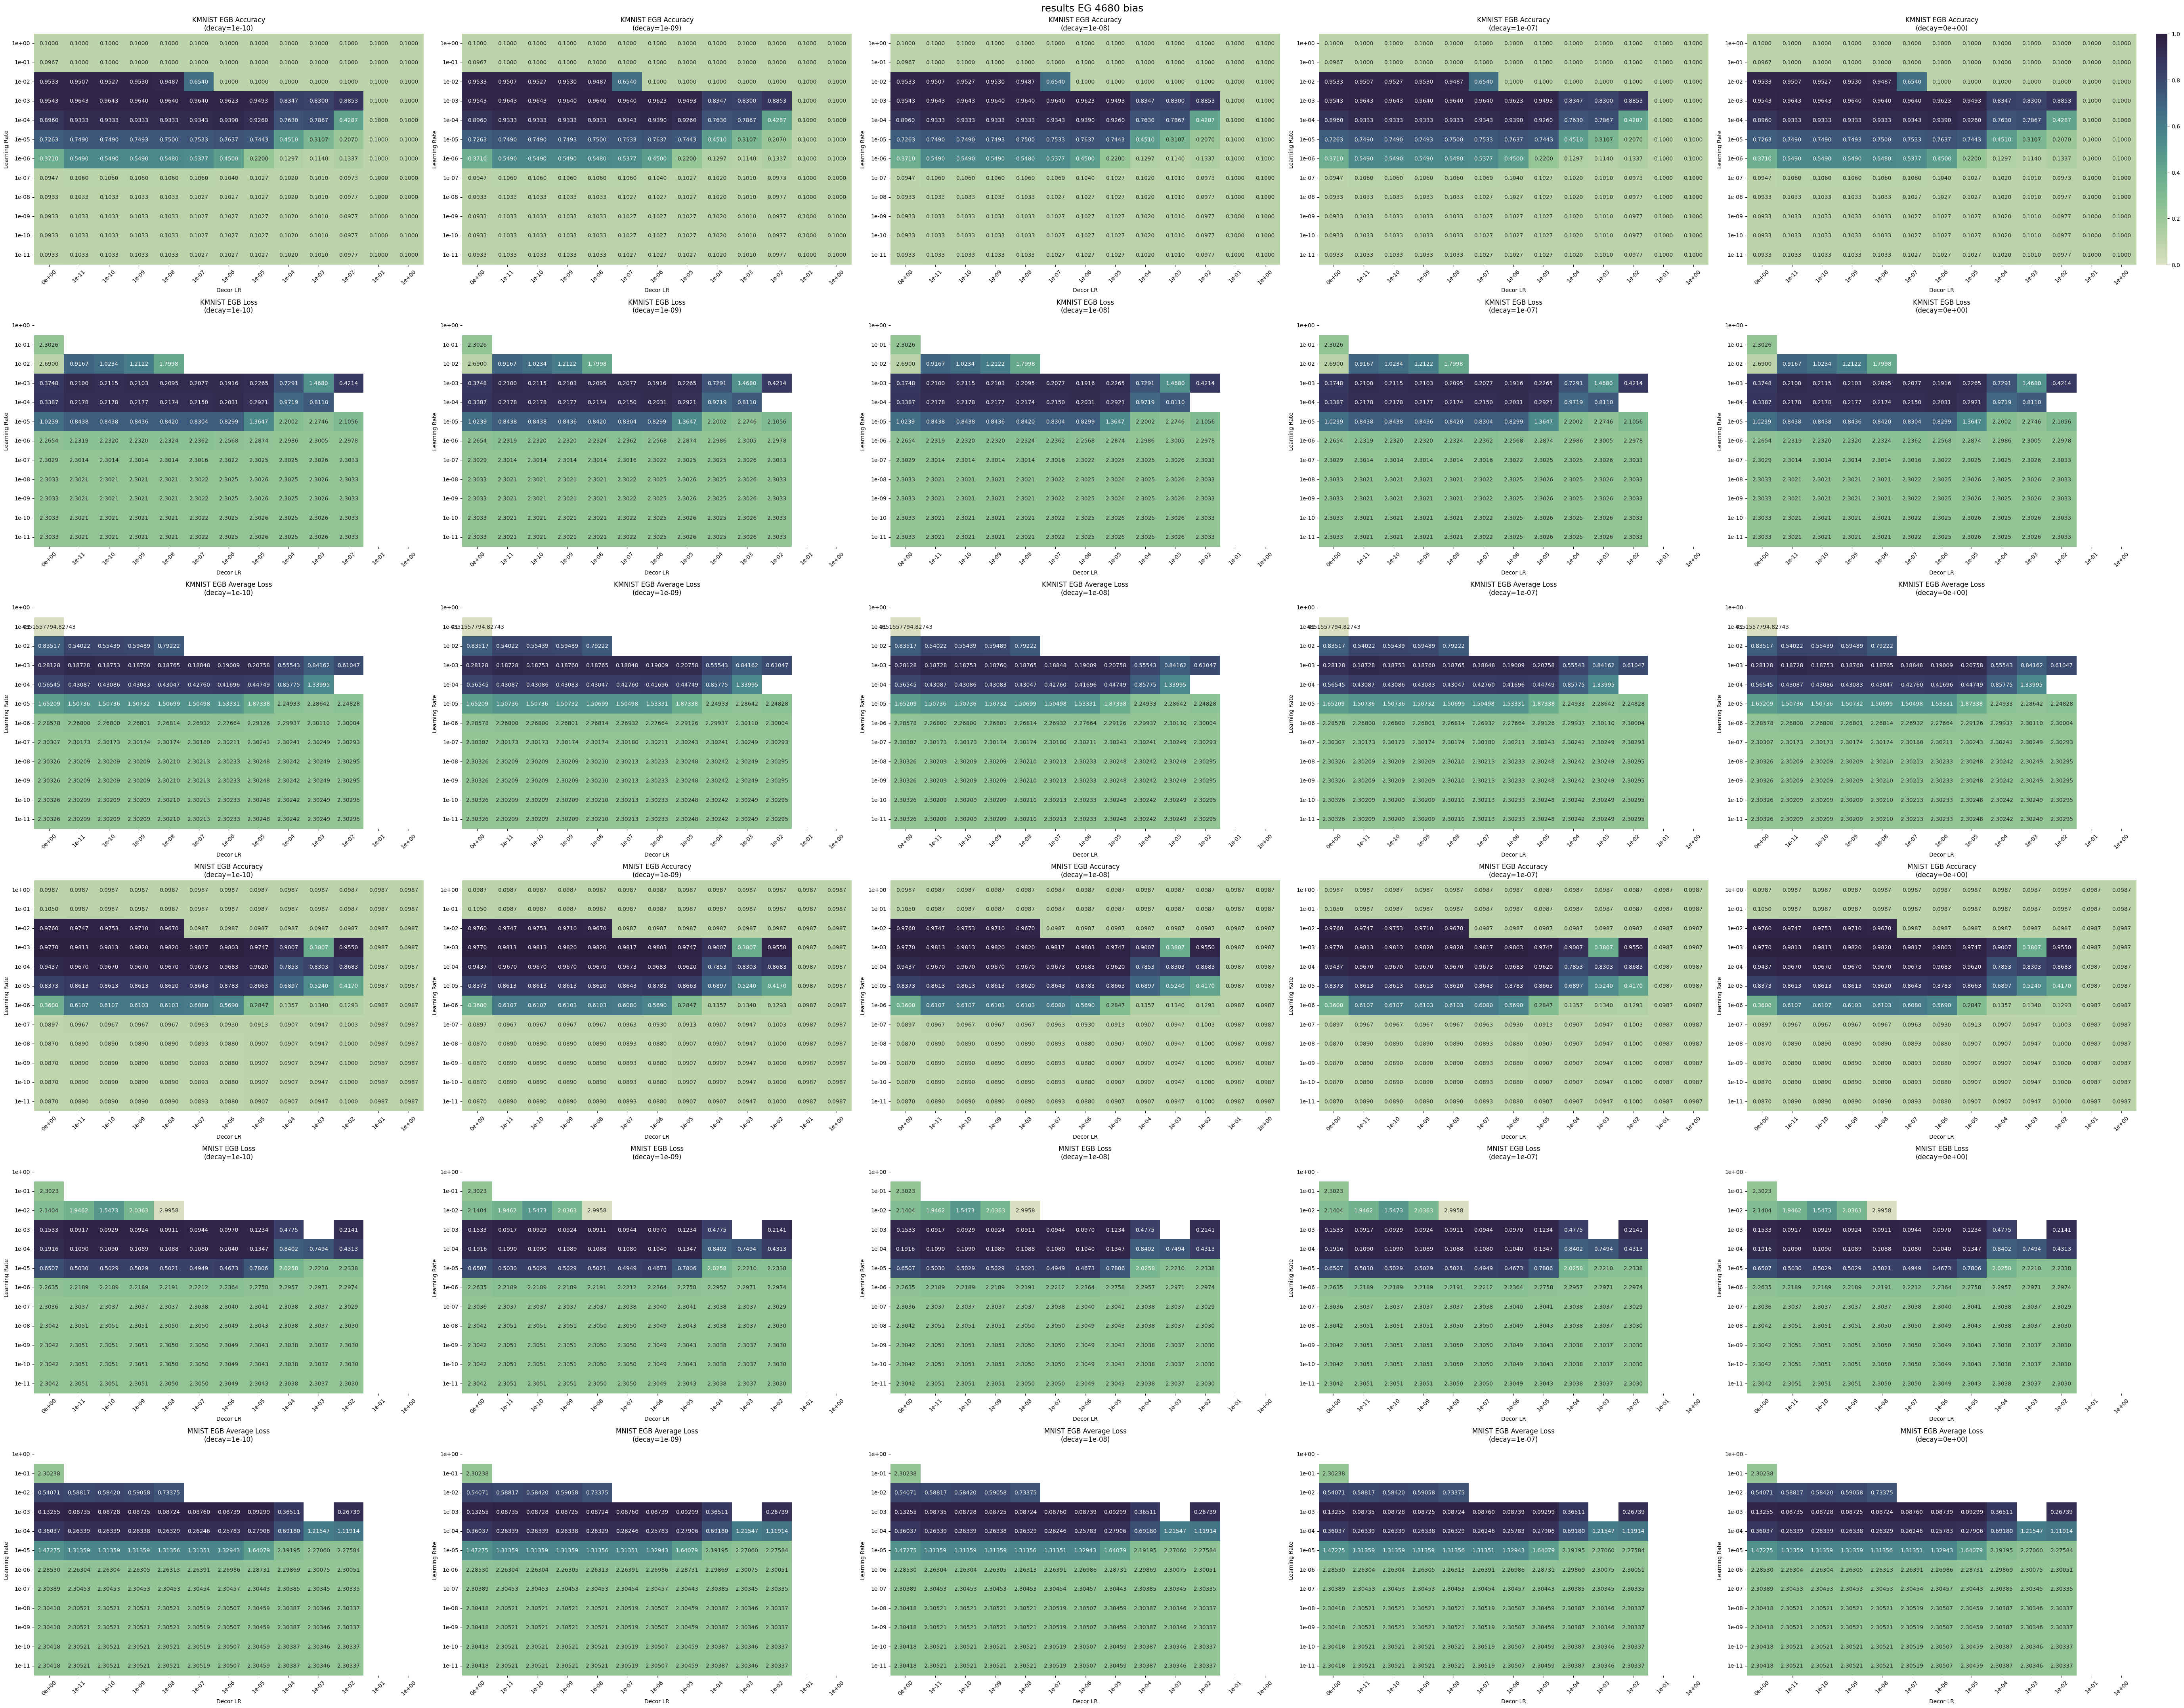

In [19]:
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
import matplotlib.colors as mcolors

# Create output directory
location = "results EG 4680 bias"
os.makedirs(f"./{location}/Graphs", exist_ok=True)

model_dir = [f"./{location}/1", f"./{location}/22", f"./{location}/42"]
all_figures = []
data1 = []
data22 = []
data42 = []

for dir in model_dir:
    print(f"Processing: {dir}")
    for fname in sorted(os.listdir(dir)):
        
        if fname.endswith(".pt"):
            fpath = os.path.join(dir, fname)

            #print(f"Processing {fname}...")
            d1 = torch.load(fpath, map_location='cpu', weights_only=False)

            stats = d1.get("stats")
            
            # Match: (cor|decor), full_lr, dlr (optional or empty), decay
            match = re.match(r'(decor|cor)-([a-zA-Z]*[\d.eE+\-]+),([\d.eE+\-]+),([\d.eE+\-]+),(\d+)\.pt', fname)

            if not match:
                print(f"Filename format unrecognized: {fname}")
                continue

            type, raw_lr, raw_dlr, raw_decay, idx = match.groups()

            # Separate LR prefix and numeric value
            lr_match = re.match(r'^([a-zA-Z]+)?([\d.eE+\-]+)$', raw_lr)
            if not lr_match:
                print(f"Could not parse LR field: {raw_lr}")
                continue
            prefix, lr_val_str = lr_match.groups()
            lr = float(lr_val_str)

            # Parse DLR (if present and non-empty)
            dlr = float(raw_dlr) if raw_dlr.strip() else None

            # Parse weight decay (always present)
            decay = float(raw_decay)
            totalLoss = 0
            for i in range(len(stats[4])):
                totalLoss+=stats[4][i]

            if(dir == f"./{location}/1"):
                data1.append({"dataset": prefix, "type": type, "val_loss":stats[4][49], "learning_rate": lr, "decor_learning_rate": dlr, "val_accuracy": stats[5][49], "decay": decay, "totalLoss": totalLoss/50})
            elif(dir == f"./{location}/22"):
                data22.append({"dataset": prefix, "type": type, "val_loss":stats[4][49], "learning_rate": lr, "decor_learning_rate": dlr, "val_accuracy": stats[5][49], "decay": decay, "totalLoss": totalLoss/50})
            elif(dir == f"./{location}/42"):
                data42.append({"dataset": prefix, "type": type, "val_loss":stats[4][49], "learning_rate": lr, "decor_learning_rate": dlr, "val_accuracy": stats[5][49], "decay": decay, "totalLoss": totalLoss/50})





print("All files processed.")

# Load into DataFrame
df1 = pd.DataFrame(data1)
df22 = pd.DataFrame(data22)
df42 = pd.DataFrame(data42)

df1.to_excel(f"./{location}/df1.xlsx")
df22.to_excel(f"./{location}/df22.xlsx")
df42.to_excel(f"./{location}/df42.xlsx")

consistent = True
for (_, row1), (_, row2), (_, row3) in zip(df1.iterrows(), df22.iterrows(), df42.iterrows()):
    dataset1 = row1["dataset"]
    dataset22 = row2["dataset"]
    dataset42 = row3["dataset"]
    
    type1 = row1["type"]
    type22 = row2["type"]
    type42 = row3["type"]

    lr1 = row1["learning_rate"]
    lr22 = row2["learning_rate"]
    lr42 = row3["learning_rate"]

    dlr1 = row1["decor_learning_rate"]
    dlr22 = row2["decor_learning_rate"]
    dlr42 = row3["decor_learning_rate"]

    decay1 = row1["decay"]
    decay22 = row2["decay"]
    decay42 = row3["decay"]
    


    if(not((dataset1 == dataset22 == dataset42) and (type1 == type22 == type42) and (lr1 == lr22 == lr42) and (dlr1 == dlr22 == dlr42) and (decay1 == decay22 == decay42))):
        consistent = False
print("####################CONSISTENCY CHECK###################: ",consistent)

EGB_cor_loss = []
EGB_cor_acc = []
EGB_decor_loss = []
EGB_decor_acc = []

data = [{}]
EGB_best_loss_reg = 100
EGB_best_loss_params_reg = [{}]

EGB_best_acc_reg = 0
EGB_best_acc_params_reg = [{}]

EGB_best_total_loss_reg = 100
EGB_best_total_loss_params_reg = [{}]

EGB_best_loss_k = 100
EGB_best_loss_params_k = [{}]

EGB_best_acc_k = 0
EGB_best_acc_params_k = [{}]

EGB_best_total_loss_k = 100
EGB_best_total_loss_params_k = [{}]

####################
EGB_cor_best_loss_reg = 100
EGB_cor_best_loss_params_reg = [{}]

EGB_cor_best_acc_reg = 0
EGB_cor_best_acc_params_reg = [{}]

EGB_cor_best_total_loss_reg = 100
EGB_cor_best_total_loss_params_reg = [{}]

EGB_cor_best_loss_k = 100
EGB_cor_best_loss_params_k = [{}]

EGB_cor_best_acc_k = 0
EGB_cor_best_acc_params_k = [{}]

EGB_cor_best_total_loss_k = 100
EGB_cor_best_total_loss_params_k = [{}]



for (_, row1), (_, row2), (_, row3) in zip(df1.iterrows(), df22.iterrows(), df42.iterrows()):
    dataset1 = row1["dataset"]
    dataset22 = row2["dataset"]
    dataset42 = row3["dataset"]
    
    type1 = row1["type"]
    type22 = row2["type"]
    type42 = row3["type"]

    lr1 = row1["learning_rate"]
    lr22 = row2["learning_rate"]
    lr42 = row3["learning_rate"]

    dlr1 = row1["decor_learning_rate"]
    dlr22 = row2["decor_learning_rate"]
    dlr42 = row3["decor_learning_rate"]

    decay1 = row1["decay"]
    decay22 = row2["decay"]
    decay42 = row3["decay"]

    val_loss1 = row1['val_loss']
    val_acc1 = row1['val_accuracy']
    totalLoss1 = row1['totalLoss']

    val_loss2 = row2['val_loss']
    val_acc2 = row2['val_accuracy']
    totalLoss2 = row2['totalLoss']

    val_loss3 = row3['val_loss']
    val_acc3 = row3['val_accuracy']
    totalLoss3 = row3['totalLoss']

    val_loss = (val_loss1+val_loss2+val_loss3)/3
    val_acc = (val_acc1+val_acc2+val_acc3)/3
    totalLoss = (totalLoss1+totalLoss2+totalLoss3)/3

    if(dlr1 == 0):
        EGB_cor_loss.append(val_loss)
        EGB_cor_acc.append(val_acc)
    
    if(dlr > 0):
        EGB_decor_loss.append(val_loss)
        EGB_decor_acc.append(val_acc)

    if((val_loss < EGB_best_loss_reg) and dataset1 == "reg"):
        EGB_best_loss_reg = val_loss
        EGB_best_loss_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if((val_acc > EGB_best_acc_reg) and dataset1 == "reg"):
        EGB_best_acc_reg = val_acc
        EGB_best_acc_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    if(totalLoss < EGB_best_total_loss_reg) and dataset1 == "reg":
        EGB_best_total_loss_reg = totalLoss
        EGB_best_total_loss_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    if((val_loss < EGB_best_loss_k) and dataset1 == "k"):
        EGB_best_loss_k = val_loss
        EGB_best_loss_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if((val_acc > EGB_best_acc_k) and dataset1 == "k"):
        EGB_best_acc_k = val_acc
        EGB_best_acc_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if(totalLoss < EGB_best_total_loss_k) and dataset1 == "k":
        EGB_best_total_loss_k = totalLoss
        EGB_best_total_loss_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    ###########################################################################################################
    if((val_loss < EGB_cor_best_loss_reg) and dataset1 == "reg" and dlr1 == 0):
        EGB_cor_best_loss_reg = val_loss
        EGB_cor_best_loss_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if((val_acc > EGB_cor_best_acc_reg) and dataset1 == "reg" and dlr1 == 0):
        EGB_cor_best_acc_reg = val_acc
        EGB_cor_best_acc_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    if((totalLoss < EGB_cor_best_total_loss_reg) and dataset1 == "reg" and dlr1 == 0):
        EGB_cor_best_total_loss_reg = totalLoss
        EGB_cor_best_total_loss_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    if((val_loss < EGB_cor_best_loss_k) and dataset1 == "k" and dlr1 == 0):
        EGB_cor_best_loss_k = val_loss
        EGB_cor_best_loss_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if((val_acc > EGB_cor_best_acc_k) and dataset1 == "k" and dlr1 == 0):
        EGB_cor_best_acc_k = val_acc
        EGB_cor_best_acc_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if((totalLoss < EGB_cor_best_total_loss_k) and dataset1 == "k"  and dlr1 == 0):
        EGB_cor_best_total_loss_k = totalLoss
        EGB_cor_best_total_loss_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    data.append({"dataset": row1["dataset"], "type": row1["type"], "val_loss":val_loss, "learning_rate": f"{lr1:.0e}", "decor_learning_rate": f"{dlr1:.0e}", "val_accuracy": val_acc, "decay": row1["decay"], "totalLoss": totalLoss})

print("acc reg: ",EGB_best_acc_params_reg)
print("loss reg: ", EGB_best_loss_params_reg)
print("total loss reg", EGB_best_total_loss_params_reg)
print("acc k: ", EGB_best_acc_params_k)
print("loss k: ", EGB_best_loss_params_k)
print("total loss k", EGB_best_total_loss_params_k)

print("###########################################################################################")

print("cor acc reg: ", EGB_cor_best_acc_params_reg)
print("cor loss reg: ", EGB_cor_best_loss_params_reg)
print("cor total loss reg", EGB_cor_best_total_loss_params_reg)
print("cor acc k: ", EGB_cor_best_acc_params_k)
print("cor loss k: ", EGB_cor_best_loss_params_k)
print("cor total loss k", EGB_cor_best_total_loss_params_k)
    


df = pd.DataFrame(data)
df.to_excel(f"./{location}/df.xlsx")







#df.to_excel("output.xlsx")

import matplotlib.pyplot as plt
import seaborn as sns

datasets = ["k", "reg"]
decay_values = [1e-10, 1e-9, 1e-8, 1e-7, 0]  # adjust as needed

fig, axes = plt.subplots(nrows=6, ncols=len(decay_values), figsize=(11 * len(decay_values), 43), constrained_layout=True)


for col, decay in enumerate(decay_values):
    for row, (dataset, metric) in enumerate([
        ("k", "val_accuracy"),
        ("k", "val_loss"),
        ("k", "totalLoss"),
        ("reg", "val_accuracy"),
        ("reg", "val_loss"),
        ("reg", "totalLoss"),
    ]):
        ax = axes[row, col]

        # Filter data for this dataset and decay
        df_fixed = df[(df["decay"] == decay) & (df["dataset"] == dataset)]
        if df_fixed.empty:
            ax.axis("off")
            #print(f"No data for decay={decay}, dataset={dataset}, metric={metric}, skipping...")
            continue

        # Pivot for heatmap
        heatmap_data = df_fixed.pivot(index="learning_rate", columns="decor_learning_rate", values=metric)

        # Sort columns numerically by converting scientific notation strings to float
        sorted_cols = sorted(heatmap_data.columns, key=lambda x: float(x))
        heatmap_data = heatmap_data[sorted_cols]
        from matplotlib.colors import PowerNorm

        
        norm = PowerNorm(gamma=1, vmin=0, vmax=1)  # gamma <1 boosts low-value contrast
    
        cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
        cmapr = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True)
        datasetName = ""
        if(dataset == "k"):
            datasetName = "KMNIST"
        elif(dataset == "reg"):
            datasetName = "MNIST"
        if row % 3 == 0:
            ax.set_title(f"{datasetName} EGB Accuracy\n(decay={decay:.0e})", fontsize=12)
            sns.heatmap(heatmap_data, norm=norm, vmin=0.0, vmax=1.0, annot=True, fmt=".4f", cmap=cmap, ax=ax, cbar=(row == 0 and col == len(decay_values) - 1))
        elif row % 3 == 1:
            ax.set_title(f"{datasetName} EGB Loss\n(decay={decay:.0e})", fontsize=12)
            sns.heatmap(heatmap_data, vmin=0.0, vmax=3.0, annot=True, fmt=".4f", cmap=cmapr, ax=ax, cbar=(row == 0 and col == len(decay_values) - 1))

        elif row % 3 == 2:
            ax.set_title(f"{datasetName} EGB Average Loss\n(decay={decay:.0e})", fontsize=12)
            sns.heatmap(heatmap_data, vmin=0.0, vmax=3.0, annot=True, fmt=".5f", cmap=cmapr, ax=ax, cbar=(row == 0 and col == len(decay_values) - 1))

        # ✅ Always show x and y axis labels
        ax.set_xlabel("Decor LR")
        ax.set_ylabel("Learning Rate")

        # Rotate x ticks for readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

        # Rotate x ticks for readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)




plt.suptitle(f"{location}", fontsize=18)
plt.savefig(f"./{location}/Graphs/heatmap_grid.png", dpi=300, bbox_inches="tight")
plt.show()



Processing: ./results EG 4680/1
Processing: ./results EG 4680/22
Processing: ./results EG 4680/42
All files processed.
####################CONSISTENCY CHECK###################:  True
acc reg:  [{'dataset': 'reg', 'type': 'decor', 'val_loss': 0.0969033330430616, 'learning_rate': ' 1e-03', 'decor_learning_rate': ' 1e-07', 'val_accuracy': 0.9823333333333334, 'decay': 0.0, 'totalLoss': 0.08835012226696858}]
loss reg:  [{'dataset': 'reg', 'type': 'decor', 'val_loss': 0.09347507092669886, 'learning_rate': ' 1e-03', 'decor_learning_rate': ' 1e-10', 'val_accuracy': 0.9819999999999999, 'decay': 0.0, 'totalLoss': 0.08793209910055753}]
total loss reg [{'dataset': 'reg', 'type': 'decor', 'val_loss': 0.09347507092669886, 'learning_rate': ' 1e-03', 'decor_learning_rate': ' 1e-10', 'val_accuracy': 0.9819999999999999, 'decay': 0.0, 'totalLoss': 0.08793209910055753}]
acc k:  [{'dataset': 'k', 'type': 'decor', 'val_loss': 0.20624793973942, 'learning_rate': ' 1e-03', 'decor_learning_rate': ' 1e-11', 'val

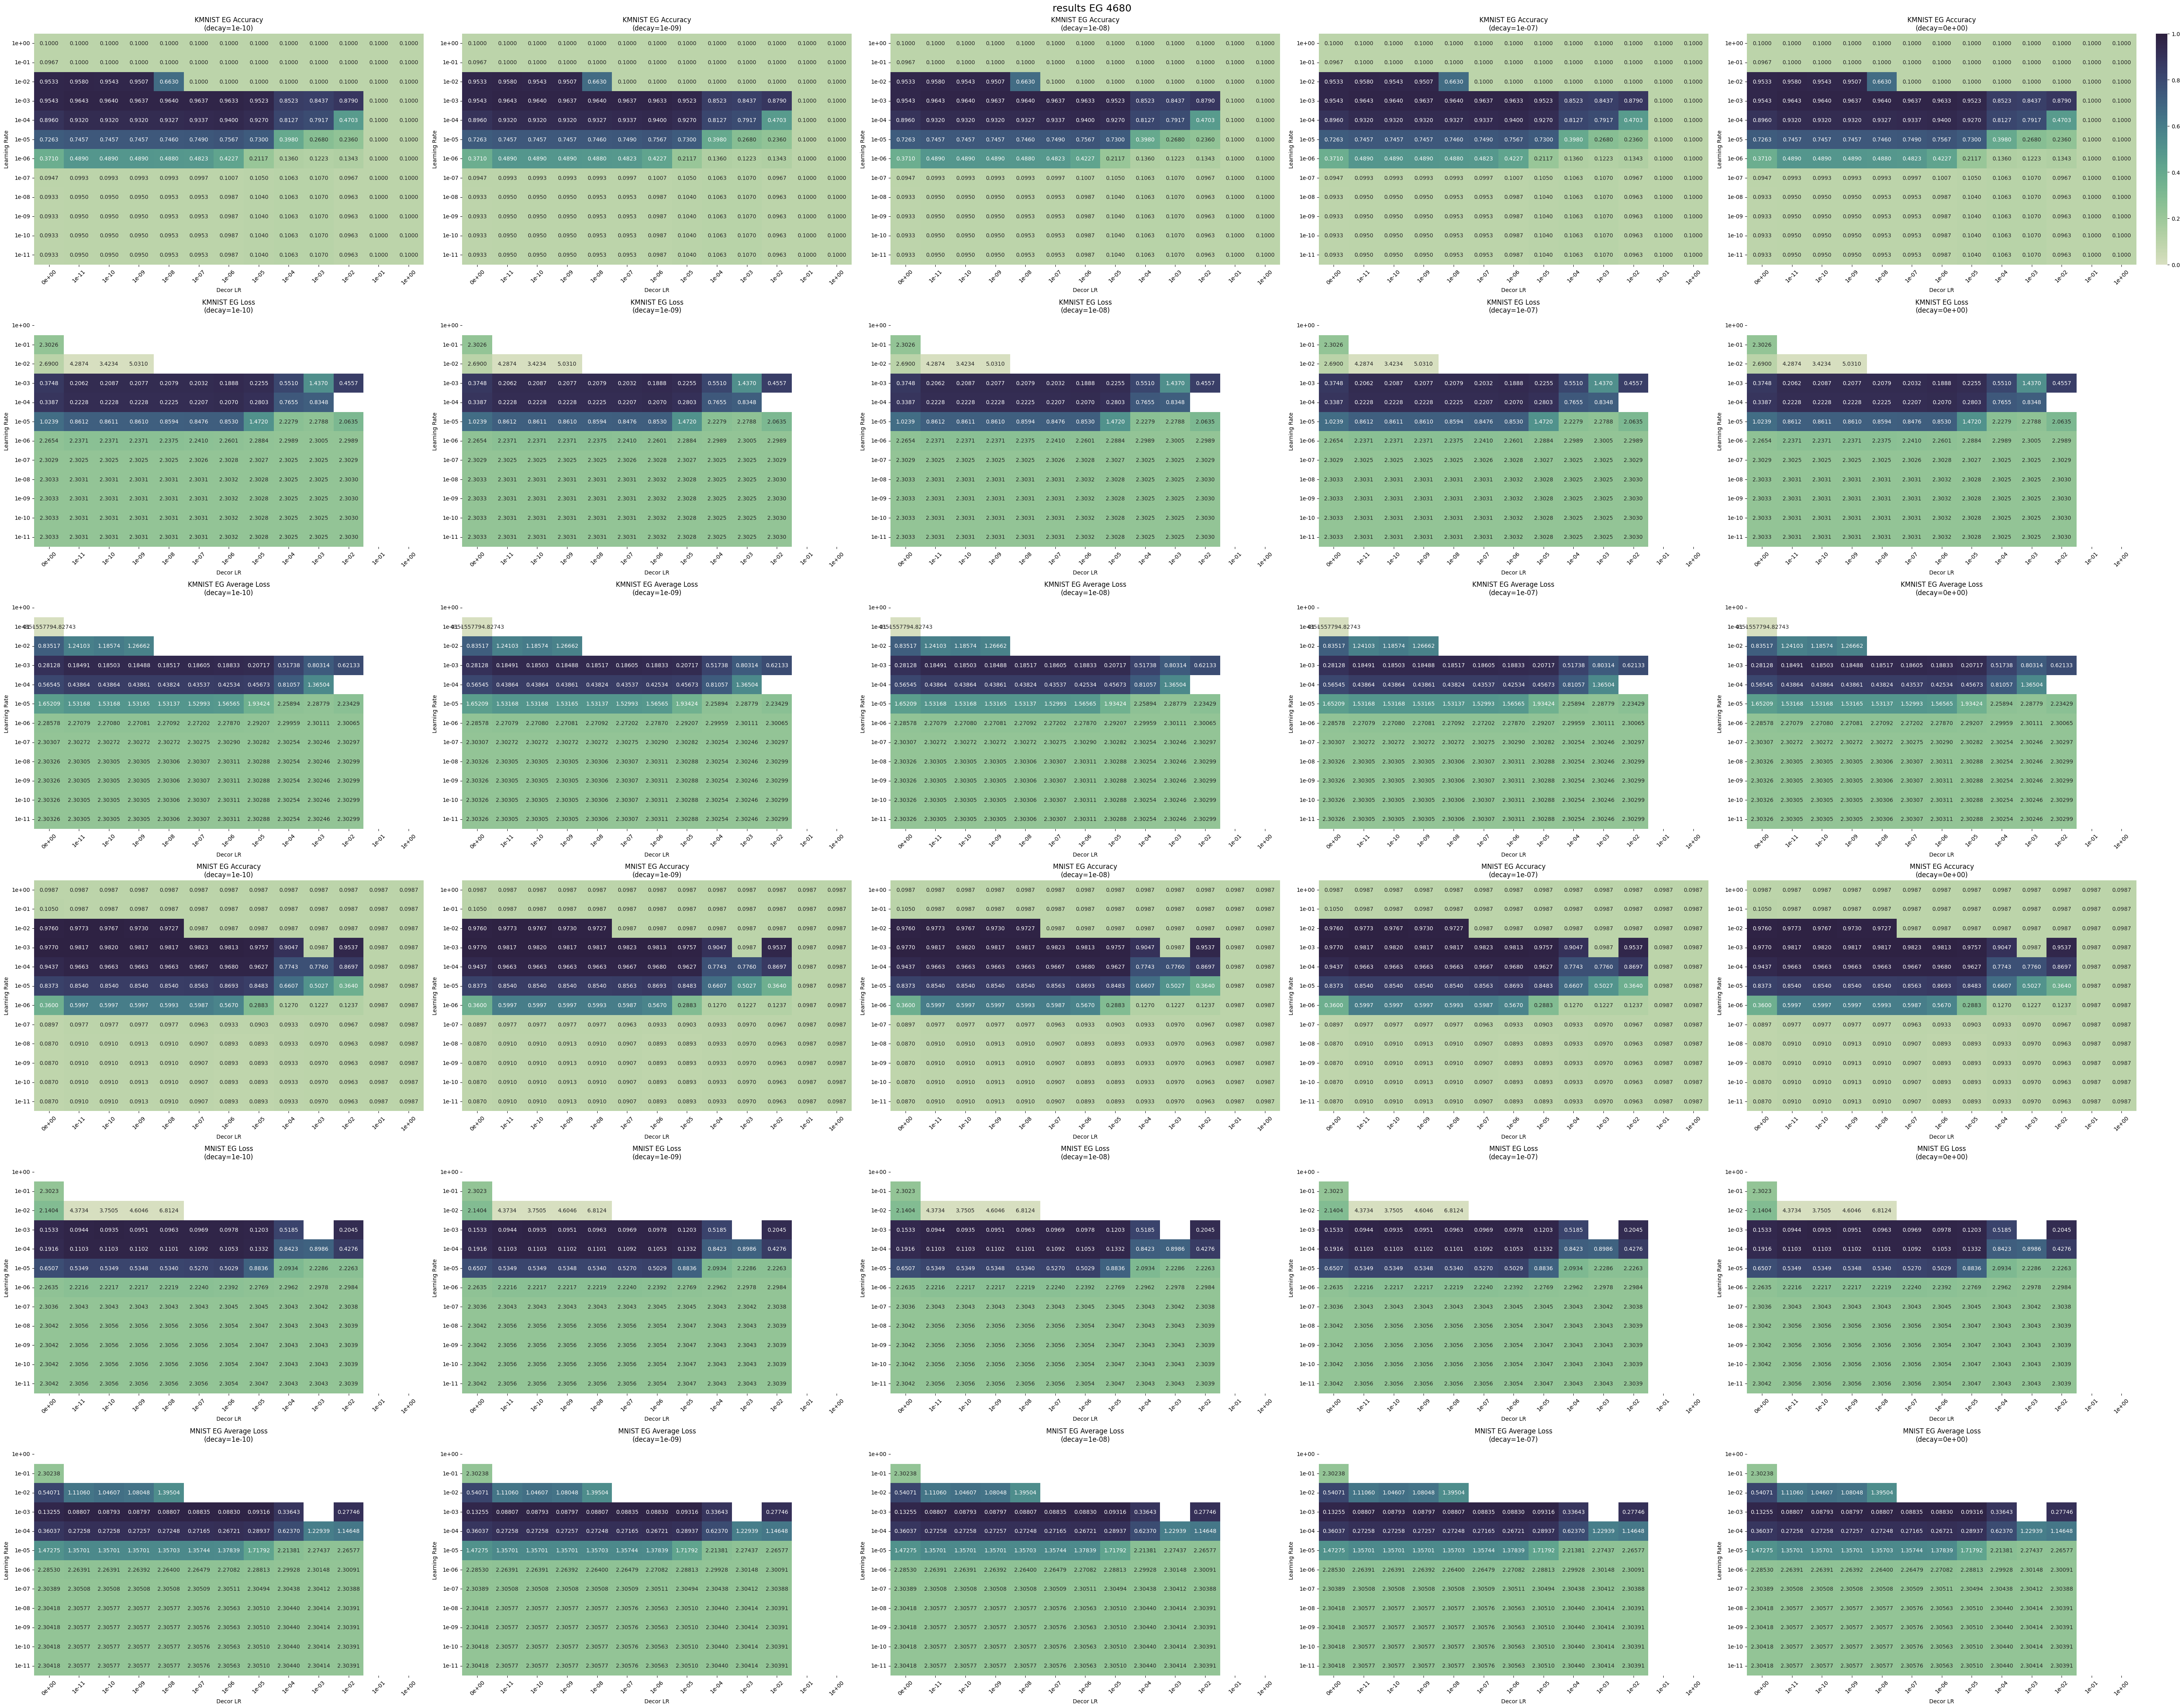

In [20]:
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
import matplotlib.colors as mcolors

# Create output directory
location = "results EG 4680"
os.makedirs(f"./{location}/Graphs", exist_ok=True)

model_dir = [f"./{location}/1", f"./{location}/22", f"./{location}/42"]
all_figures = []
data1 = []
data22 = []
data42 = []

for dir in model_dir:
    print(f"Processing: {dir}")
    for fname in sorted(os.listdir(dir)):
        
        if fname.endswith(".pt"):
            fpath = os.path.join(dir, fname)

            #print(f"Processing {fname}...")
            d1 = torch.load(fpath, map_location='cpu', weights_only=False)

            stats = d1.get("stats")
            
            # Match: (cor|decor), full_lr, dlr (optional or empty), decay
            match = re.match(r'(decor|cor)-([a-zA-Z]*[\d.eE+\-]+),([\d.eE+\-]+),([\d.eE+\-]+),(\d+)\.pt', fname)

            if not match:
                print(f"Filename format unrecognized: {fname}")
                continue

            type, raw_lr, raw_dlr, raw_decay, idx = match.groups()

            # Separate LR prefix and numeric value
            lr_match = re.match(r'^([a-zA-Z]+)?([\d.eE+\-]+)$', raw_lr)
            if not lr_match:
                print(f"Could not parse LR field: {raw_lr}")
                continue
            prefix, lr_val_str = lr_match.groups()
            lr = float(lr_val_str)

            # Parse DLR (if present and non-empty)
            dlr = float(raw_dlr) if raw_dlr.strip() else None

            # Parse weight decay (always present)
            decay = float(raw_decay)
            totalLoss = 0
            for i in range(len(stats[4])):
                totalLoss+=stats[4][i]

            if(dir == f"./{location}/1"):
                data1.append({"dataset": prefix, "type": type, "val_loss":stats[4][49], "learning_rate": lr, "decor_learning_rate": dlr, "val_accuracy": stats[5][49], "decay": decay, "totalLoss": totalLoss/50})
            elif(dir == f"./{location}/22"):
                data22.append({"dataset": prefix, "type": type, "val_loss":stats[4][49], "learning_rate": lr, "decor_learning_rate": dlr, "val_accuracy": stats[5][49], "decay": decay, "totalLoss": totalLoss/50})
            elif(dir == f"./{location}/42"):
                data42.append({"dataset": prefix, "type": type, "val_loss":stats[4][49], "learning_rate": lr, "decor_learning_rate": dlr, "val_accuracy": stats[5][49], "decay": decay, "totalLoss": totalLoss/50})





print("All files processed.")

# Load into DataFrame
df1 = pd.DataFrame(data1)
df22 = pd.DataFrame(data22)
df42 = pd.DataFrame(data42)

df1.to_excel(f"./{location}/df1.xlsx")
df22.to_excel(f"./{location}/df22.xlsx")
df42.to_excel(f"./{location}/df42.xlsx")

consistent = True
for (_, row1), (_, row2), (_, row3) in zip(df1.iterrows(), df22.iterrows(), df42.iterrows()):
    dataset1 = row1["dataset"]
    dataset22 = row2["dataset"]
    dataset42 = row3["dataset"]
    
    type1 = row1["type"]
    type22 = row2["type"]
    type42 = row3["type"]

    lr1 = row1["learning_rate"]
    lr22 = row2["learning_rate"]
    lr42 = row3["learning_rate"]

    dlr1 = row1["decor_learning_rate"]
    dlr22 = row2["decor_learning_rate"]
    dlr42 = row3["decor_learning_rate"]

    decay1 = row1["decay"]
    decay22 = row2["decay"]
    decay42 = row3["decay"]
    


    if(not((dataset1 == dataset22 == dataset42) and (type1 == type22 == type42) and (lr1 == lr22 == lr42) and (dlr1 == dlr22 == dlr42) and (decay1 == decay22 == decay42))):
        consistent = False
print("####################CONSISTENCY CHECK###################: ",consistent)

EG_cor_loss = []
EG_cor_acc = []
EG_decor_loss = []
EG_decor_acc = []

data = [{}]
EG_best_loss_reg = 100
EG_best_loss_params_reg = [{}]

EG_best_acc_reg = 0
EG_best_acc_params_reg = [{}]

EG_best_total_loss_reg = 100
EG_best_total_loss_params_reg = [{}]

EG_best_loss_k = 100
EG_best_loss_params_k = [{}]

EG_best_acc_k = 0
EG_best_acc_params_k = [{}]

EG_best_total_loss_k = 100
EG_best_total_loss_params_k = [{}]

####################
EG_cor_best_loss_reg = 100
EG_cor_best_loss_params_reg = [{}]

EG_cor_best_acc_reg = 0
EG_cor_best_acc_params_reg = [{}]

EG_cor_best_total_loss_reg = 100
EG_cor_best_total_loss_params_reg = [{}]

EG_cor_best_loss_k = 100
EG_cor_best_loss_params_k = [{}]

EG_cor_best_acc_k = 0
EG_cor_best_acc_params_k = [{}]

EG_cor_best_total_loss_k = 100
EG_cor_best_total_loss_params_k = [{}]



for (_, row1), (_, row2), (_, row3) in zip(df1.iterrows(), df22.iterrows(), df42.iterrows()):
    dataset1 = row1["dataset"]
    dataset22 = row2["dataset"]
    dataset42 = row3["dataset"]
    
    type1 = row1["type"]
    type22 = row2["type"]
    type42 = row3["type"]

    lr1 = row1["learning_rate"]
    lr22 = row2["learning_rate"]
    lr42 = row3["learning_rate"]

    dlr1 = row1["decor_learning_rate"]
    dlr22 = row2["decor_learning_rate"]
    dlr42 = row3["decor_learning_rate"]

    decay1 = row1["decay"]
    decay22 = row2["decay"]
    decay42 = row3["decay"]

    val_loss1 = row1['val_loss']
    val_acc1 = row1['val_accuracy']
    totalLoss1 = row1['totalLoss']

    val_loss2 = row2['val_loss']
    val_acc2 = row2['val_accuracy']
    totalLoss2 = row2['totalLoss']

    val_loss3 = row3['val_loss']
    val_acc3 = row3['val_accuracy']
    totalLoss3 = row3['totalLoss']

    val_loss = (val_loss1+val_loss2+val_loss3)/3
    val_acc = (val_acc1+val_acc2+val_acc3)/3
    totalLoss = (totalLoss1+totalLoss2+totalLoss3)/3

    if(dlr1 == 0):
        EG_cor_loss.append(val_loss)
        EG_cor_acc.append(val_acc)
    
    if(dlr > 0):
        EG_decor_loss.append(val_loss)
        EG_decor_acc.append(val_acc)

    if((val_loss < EG_best_loss_reg) and dataset1 == "reg"):
        EG_best_loss_reg = val_loss
        EG_best_loss_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if((val_acc > EG_best_acc_reg) and dataset1 == "reg"):
        EG_best_acc_reg = val_acc
        EG_best_acc_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    if(totalLoss < EG_best_total_loss_reg) and dataset1 == "reg":
        EG_best_total_loss_reg = totalLoss
        EG_best_total_loss_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    if((val_loss < EG_best_loss_k) and dataset1 == "k"):
        EG_best_loss_k = val_loss
        EG_best_loss_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if((val_acc > EG_best_acc_k) and dataset1 == "k"):
        EG_best_acc_k = val_acc
        EG_best_acc_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if(totalLoss < EG_best_total_loss_k) and dataset1 == "k":
        EG_best_total_loss_k = totalLoss
        EG_best_total_loss_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    ###########################################################################################################
    if((val_loss < EG_cor_best_loss_reg) and dataset1 == "reg" and dlr1 == 0):
        EG_cor_best_loss_reg = val_loss
        EG_cor_best_loss_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if((val_acc > EG_cor_best_acc_reg) and dataset1 == "reg" and dlr1 == 0):
        EG_cor_best_acc_reg = val_acc
        EG_cor_best_acc_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    if((totalLoss < EG_cor_best_total_loss_reg) and dataset1 == "reg" and dlr1 == 0):
        EG_cor_best_total_loss_reg = totalLoss
        EG_cor_best_total_loss_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    if((val_loss < EG_cor_best_loss_k) and dataset1 == "k" and dlr1 == 0):
        EG_cor_best_loss_k = val_loss
        EG_cor_best_loss_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if((val_acc > EG_cor_best_acc_k) and dataset1 == "k" and dlr1 == 0):
        EG_cor_best_acc_k = val_acc
        EG_cor_best_acc_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if((totalLoss < EG_cor_best_total_loss_k) and dataset1 == "k"  and dlr1 == 0):
        EG_cor_best_total_loss_k = totalLoss
        EG_cor_best_total_loss_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    data.append({"dataset": row1["dataset"], "type": row1["type"], "val_loss":val_loss, "learning_rate": f"{lr1:.0e}", "decor_learning_rate": f"{dlr1:.0e}", "val_accuracy": val_acc, "decay": row1["decay"], "totalLoss": totalLoss})

print("acc reg: ", EG_best_acc_params_reg)
print("loss reg: ", EG_best_loss_params_reg)
print("total loss reg", EG_best_total_loss_params_reg)
print("acc k: ", EG_best_acc_params_k)
print("loss k: ", EG_best_loss_params_k)
print("total loss k", EG_best_total_loss_params_k)

print("###########################################################################################")

print("cor acc reg: ", EG_cor_best_acc_params_reg)
print("cor loss reg: ", EG_cor_best_loss_params_reg)
print("cor total loss reg", EG_cor_best_total_loss_params_reg)
print("cor acc k: ", EG_cor_best_acc_params_k)
print("cor loss k: ", EG_cor_best_loss_params_k)
print("cor total loss k", EG_cor_best_total_loss_params_k)
    


df = pd.DataFrame(data)
df.to_excel(f"./{location}/df.xlsx")







#df.to_excel("output.xlsx")

import matplotlib.pyplot as plt
import seaborn as sns

datasets = ["k", "reg"]
decay_values = [1e-10, 1e-9, 1e-8, 1e-7, 0]  # adjust as needed

fig, axes = plt.subplots(nrows=6, ncols=len(decay_values), figsize=(11 * len(decay_values), 43), constrained_layout=True)


for col, decay in enumerate(decay_values):
    for row, (dataset, metric) in enumerate([
        ("k", "val_accuracy"),
        ("k", "val_loss"),
        ("k", "totalLoss"),
        ("reg", "val_accuracy"),
        ("reg", "val_loss"),
        ("reg", "totalLoss"),
    ]):
        ax = axes[row, col]

        # Filter data for this dataset and decay
        df_fixed = df[(df["decay"] == decay) & (df["dataset"] == dataset)]
        if df_fixed.empty:
            ax.axis("off")
            #print(f"No data for decay={decay}, dataset={dataset}, metric={metric}, skipping...")
            continue

        # Pivot for heatmap
        heatmap_data = df_fixed.pivot(index="learning_rate", columns="decor_learning_rate", values=metric)

        # Sort columns numerically by converting scientific notation strings to float
        sorted_cols = sorted(heatmap_data.columns, key=lambda x: float(x))
        heatmap_data = heatmap_data[sorted_cols]
        from matplotlib.colors import PowerNorm

        
        norm = PowerNorm(gamma=1, vmin=0, vmax=1)  # gamma <1 boosts low-value contrast
    
        cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
        cmapr = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True)
        datasetName = ""
        if(dataset == "k"):
            datasetName = "KMNIST"
        elif(dataset == "reg"):
            datasetName = "MNIST"
        if row % 3 == 0:
            ax.set_title(f"{datasetName} EG Accuracy\n(decay={decay:.0e})", fontsize=12)
            sns.heatmap(heatmap_data, norm=norm, vmin=0.0, vmax=1.0, annot=True, fmt=".4f", cmap=cmap, ax=ax, cbar=(row == 0 and col == len(decay_values) - 1))
        elif row % 3 == 1:
            ax.set_title(f"{datasetName} EG Loss\n(decay={decay:.0e})", fontsize=12)
            sns.heatmap(heatmap_data, vmin=0.0, vmax=3.0, annot=True, fmt=".4f", cmap=cmapr, ax=ax, cbar=(row == 0 and col == len(decay_values) - 1))

        elif row % 3 == 2:
            ax.set_title(f"{datasetName} EG Average Loss\n(decay={decay:.0e})", fontsize=12)
            sns.heatmap(heatmap_data, vmin=0.0, vmax=3.0, annot=True, fmt=".5f", cmap=cmapr, ax=ax, cbar=(row == 0 and col == len(decay_values) - 1))

        # ✅ Always show x and y axis labels
        ax.set_xlabel("Decor LR")
        ax.set_ylabel("Learning Rate")

        # Rotate x ticks for readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

        # Rotate x ticks for readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)




plt.suptitle(f"{location}", fontsize=18)
plt.savefig(f"./{location}/Graphs/heatmap_grid.png", dpi=300, bbox_inches="tight")
plt.show()



Processing: ./results regular 4680/1
Processing: ./results regular 4680/22
Processing: ./results regular 4680/42
All files processed.
####################CONSISTENCY CHECK###################:  True
acc reg:  [{'dataset': 'reg', 'type': 'decor', 'val_loss': 0.10753098799031376, 'learning_rate': ' 1e-04', 'decor_learning_rate': ' 1e-10', 'val_accuracy': 0.9826666666666667, 'decay': 0.0, 'totalLoss': 0.09232684688661962}]
loss reg:  [{'dataset': 'reg', 'type': 'decor', 'val_loss': 0.06569352935784467, 'learning_rate': ' 1e-05', 'decor_learning_rate': ' 1e-10', 'val_accuracy': 0.981, 'decay': 0.0, 'totalLoss': 0.10654446069064351}]
total loss reg [{'dataset': 'reg', 'type': 'decor', 'val_loss': 0.1108541293801326, 'learning_rate': ' 1e-04', 'decor_learning_rate': ' 1e-05', 'val_accuracy': 0.9780000000000001, 'decay': 0.0, 'totalLoss': 0.07870922817193826}]
acc k:  [{'dataset': 'k', 'type': 'decor', 'val_loss': 0.1491260540448246, 'learning_rate': ' 1e-04', 'decor_learning_rate': ' 1e-06', 

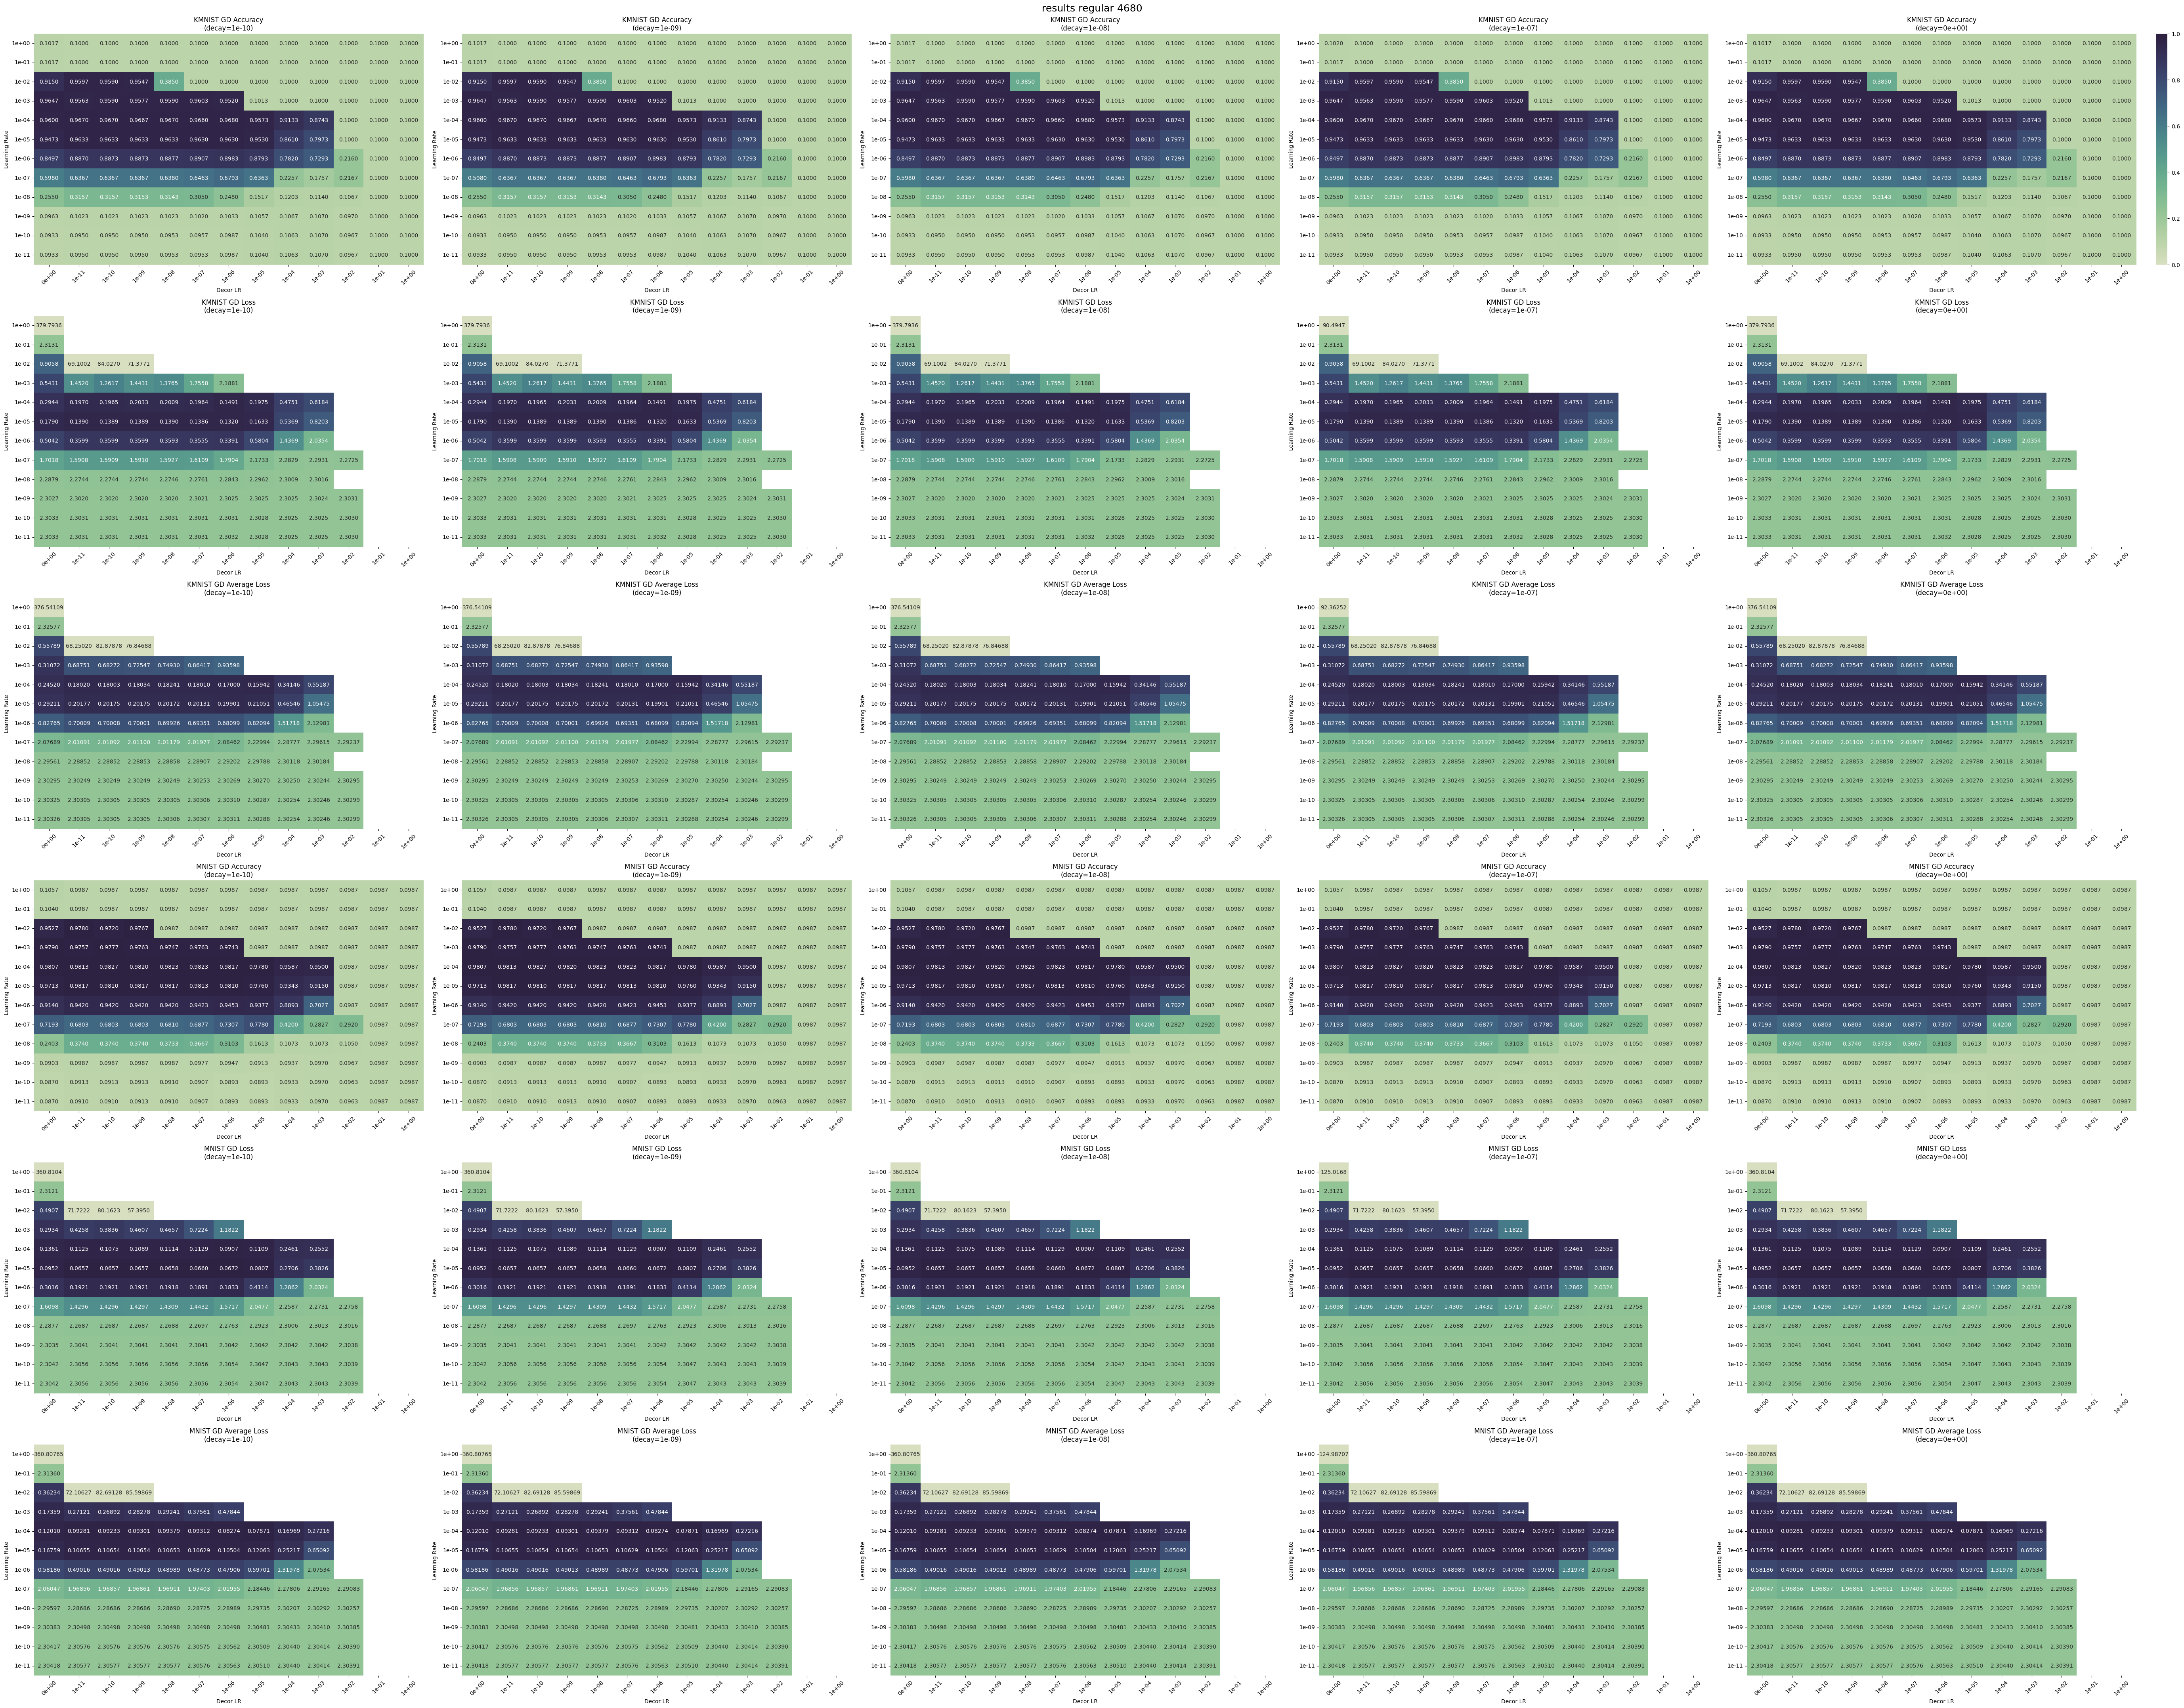

In [35]:
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
import matplotlib.colors as mcolors

# Create output directory
location = "results regular 4680"
os.makedirs(f"./{location}/Graphs", exist_ok=True)

model_dir = [f"./{location}/1", f"./{location}/22", f"./{location}/42"]
all_figures = []
data1 = []
data22 = []
data42 = []

for dir in model_dir:
    print(f"Processing: {dir}")
    for fname in sorted(os.listdir(dir)):
        
        if fname.endswith(".pt"):
            fpath = os.path.join(dir, fname)

            #print(f"Processing {fname}...")
            d1 = torch.load(fpath, map_location='cpu', weights_only=False)

            stats = d1.get("stats")
            
            # Match: (cor|decor), full_lr, dlr (optional or empty), decay
            match = re.match(r'(decor|cor)-([a-zA-Z]*[\d.eE+\-]+),([\d.eE+\-]+),([\d.eE+\-]+),(\d+)\.pt', fname)

            if not match:
                print(f"Filename format unrecognized: {fname}")
                continue

            type, raw_lr, raw_dlr, raw_decay, idx = match.groups()

            # Separate LR prefix and numeric value
            lr_match = re.match(r'^([a-zA-Z]+)?([\d.eE+\-]+)$', raw_lr)
            if not lr_match:
                print(f"Could not parse LR field: {raw_lr}")
                continue
            prefix, lr_val_str = lr_match.groups()
            lr = float(lr_val_str)

            # Parse DLR (if present and non-empty)
            dlr = float(raw_dlr) if raw_dlr.strip() else None

            # Parse weight decay (always present)
            decay = float(raw_decay)
            totalLoss = 0
            for i in range(len(stats[4])):
                totalLoss+=stats[4][i]

            if(dir == f"./{location}/1"):
                data1.append({"dataset": prefix, "type": type, "val_loss":stats[4][49], "learning_rate": lr, "decor_learning_rate": dlr, "val_accuracy": stats[5][49], "decay": decay, "totalLoss": totalLoss/50})
            elif(dir == f"./{location}/22"):
                data22.append({"dataset": prefix, "type": type, "val_loss":stats[4][49], "learning_rate": lr, "decor_learning_rate": dlr, "val_accuracy": stats[5][49], "decay": decay, "totalLoss": totalLoss/50})
            elif(dir == f"./{location}/42"):
                data42.append({"dataset": prefix, "type": type, "val_loss":stats[4][49], "learning_rate": lr, "decor_learning_rate": dlr, "val_accuracy": stats[5][49], "decay": decay, "totalLoss": totalLoss/50})





print("All files processed.")

# Load into DataFrame
df1 = pd.DataFrame(data1)
df22 = pd.DataFrame(data22)
df42 = pd.DataFrame(data42)

df1.to_excel(f"./{location}/df1.xlsx")
df22.to_excel(f"./{location}/df22.xlsx")
df42.to_excel(f"./{location}/df42.xlsx")

consistent = True
for (_, row1), (_, row2), (_, row3) in zip(df1.iterrows(), df22.iterrows(), df42.iterrows()):
    dataset1 = row1["dataset"]
    dataset22 = row2["dataset"]
    dataset42 = row3["dataset"]
    
    type1 = row1["type"]
    type22 = row2["type"]
    type42 = row3["type"]

    lr1 = row1["learning_rate"]
    lr22 = row2["learning_rate"]
    lr42 = row3["learning_rate"]

    dlr1 = row1["decor_learning_rate"]
    dlr22 = row2["decor_learning_rate"]
    dlr42 = row3["decor_learning_rate"]

    decay1 = row1["decay"]
    decay22 = row2["decay"]
    decay42 = row3["decay"]
    


    if(not((dataset1 == dataset22 == dataset42) and (type1 == type22 == type42) and (lr1 == lr22 == lr42) and (dlr1 == dlr22 == dlr42) and (decay1 == decay22 == decay42))):
        consistent = False
print("####################CONSISTENCY CHECK###################: ",consistent)

R_cor_loss = []
R_cor_acc = []
R_decor_loss = []
R_decor_acc = []

data = [{}]
R_best_loss_reg = 100
R_best_loss_params_reg = [{}]

R_best_acc_reg = 0
R_best_acc_params_reg = [{}]

R_best_total_loss_reg = 100
R_best_total_loss_params_reg = [{}]

R_best_loss_k = 100
R_best_loss_params_k = [{}]

R_best_acc_k = 0
R_best_acc_params_k = [{}]

R_best_total_loss_k = 100
R_best_total_loss_params_k = [{}]

####################
R_cor_best_loss_reg = 100
R_cor_best_loss_params_reg = [{}]

R_cor_best_acc_reg = 0
R_cor_best_acc_params_reg = [{}]

R_cor_best_total_loss_reg = 100
R_cor_best_total_loss_params_reg = [{}]

R_cor_best_loss_k = 100
R_cor_best_loss_params_k = [{}]

R_cor_best_acc_k = 0
R_cor_best_acc_params_k = [{}]

R_cor_best_total_loss_k = 100
R_cor_best_total_loss_params_k = [{}]



for (_, row1), (_, row2), (_, row3) in zip(df1.iterrows(), df22.iterrows(), df42.iterrows()):
    dataset1 = row1["dataset"]
    dataset22 = row2["dataset"]
    dataset42 = row3["dataset"]
    
    type1 = row1["type"]
    type22 = row2["type"]
    type42 = row3["type"]

    lr1 = row1["learning_rate"]
    lr22 = row2["learning_rate"]
    lr42 = row3["learning_rate"]

    dlr1 = row1["decor_learning_rate"]
    dlr22 = row2["decor_learning_rate"]
    dlr42 = row3["decor_learning_rate"]

    decay1 = row1["decay"]
    decay22 = row2["decay"]
    decay42 = row3["decay"]

    val_loss1 = row1['val_loss']
    val_acc1 = row1['val_accuracy']
    totalLoss1 = row1['totalLoss']

    val_loss2 = row2['val_loss']
    val_acc2 = row2['val_accuracy']
    totalLoss2 = row2['totalLoss']

    val_loss3 = row3['val_loss']
    val_acc3 = row3['val_accuracy']
    totalLoss3 = row3['totalLoss']

    val_loss = (val_loss1+val_loss2+val_loss3)/3
    val_acc = (val_acc1+val_acc2+val_acc3)/3
    totalLoss = (totalLoss1+totalLoss2+totalLoss3)/3

    if(dlr1 == 0):
        R_cor_loss.append(val_loss)
        R_cor_acc.append(val_acc)
    
    if(dlr > 0):
        R_decor_loss.append(val_loss)
        R_decor_acc.append(val_acc)

    if((val_loss < R_best_loss_reg) and dataset1 == "reg"):
        R_best_loss_reg = val_loss
        R_best_loss_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if((val_acc > R_best_acc_reg) and dataset1 == "reg"):
        R_best_acc_reg = val_acc
        R_best_acc_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    if(totalLoss < R_best_total_loss_reg) and dataset1 == "reg":
        R_best_total_loss_reg = totalLoss
        R_best_total_loss_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    if((val_loss < R_best_loss_k) and dataset1 == "k"):
        R_best_loss_k = val_loss
        R_best_loss_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if((val_acc > R_best_acc_k) and dataset1 == "k"):
        R_best_acc_k = val_acc
        R_best_acc_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if(totalLoss < R_best_total_loss_k) and dataset1 == "k":
        R_best_total_loss_k = totalLoss
        R_best_total_loss_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    ###########################################################################################################
    if((val_loss < R_cor_best_loss_reg) and dataset1 == "reg" and dlr1 == 0):
        R_cor_best_loss_reg = val_loss
        R_cor_best_loss_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if((val_acc > R_cor_best_acc_reg) and dataset1 == "reg" and dlr1 == 0):
        R_cor_best_acc_reg = val_acc
        R_cor_best_acc_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    if((totalLoss < R_cor_best_total_loss_reg) and dataset1 == "reg" and dlr1 == 0):
        R_cor_best_total_loss_reg = totalLoss
        R_cor_best_total_loss_params_reg[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    if((val_loss < R_cor_best_loss_k) and dataset1 == "k" and dlr1 == 0):
        R_cor_best_loss_k = val_loss
        R_cor_best_loss_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if((val_acc > R_cor_best_acc_k) and dataset1 == "k" and dlr1 == 0):
        R_cor_best_acc_k = val_acc
        R_cor_best_acc_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})
    
    if((totalLoss < R_cor_best_total_loss_k) and dataset1 == "k"  and dlr1 == 0):
        R_cor_best_total_loss_k = totalLoss
        R_cor_best_total_loss_params_k[0] = ({"dataset": dataset1, "type": type1, "val_loss": val_loss, "learning_rate": f"{lr1: .0e}", "decor_learning_rate": f"{dlr1: .0e}", "val_accuracy": val_acc, "decay": decay1, "totalLoss": totalLoss})

    data.append({"dataset": row1["dataset"], "type": row1["type"], "val_loss":val_loss, "learning_rate": f"{lr1:.0e}", "decor_learning_rate": f"{dlr1:.0e}", "val_accuracy": val_acc, "decay": row1["decay"], "totalLoss": totalLoss})

print("acc reg: ", R_best_acc_params_reg)
print("loss reg: ", R_best_loss_params_reg)
print("total loss reg", R_best_total_loss_params_reg)
print("acc k: ", R_best_acc_params_k)
print("loss k: ", R_best_loss_params_k)
print("total loss k", R_best_total_loss_params_k)

print("###########################################################################################")

print("cor acc reg: ", R_cor_best_acc_params_reg)
print("cor loss reg: ", R_cor_best_loss_params_reg)
print("cor total loss reg", R_cor_best_total_loss_params_reg)
print("cor acc k: ", R_cor_best_acc_params_k)
print("cor loss k: ", R_cor_best_loss_params_k)
print("cor total loss k", R_cor_best_total_loss_params_k)
    


df = pd.DataFrame(data)
df.to_excel(f"./{location}/df.xlsx")







#df.to_excel("output.xlsx")

import matplotlib.pyplot as plt
import seaborn as sns

datasets = ["k", "reg"]
decay_values = [1e-10, 1e-9, 1e-8, 1e-7, 0]  # adjust as needed

fig, axes = plt.subplots(nrows=6, ncols=len(decay_values), figsize=(11 * len(decay_values), 43), constrained_layout=True)


for col, decay in enumerate(decay_values):
    for row, (dataset, metric) in enumerate([
        ("k", "val_accuracy"),
        ("k", "val_loss"),
        ("k", "totalLoss"),
        ("reg", "val_accuracy"),
        ("reg", "val_loss"),
        ("reg", "totalLoss"),
    ]):
        ax = axes[row, col]

        # Filter data for this dataset and decay
        df_fixed = df[(df["decay"] == decay) & (df["dataset"] == dataset)]
        if df_fixed.empty:
            ax.axis("off")
            #print(f"No data for decay={decay}, dataset={dataset}, metric={metric}, skipping...")
            continue

        # Pivot for heatmap
        heatmap_data = df_fixed.pivot(index="learning_rate", columns="decor_learning_rate", values=metric)

        # Sort columns numerically by converting scientific notation strings to float
        sorted_cols = sorted(heatmap_data.columns, key=lambda x: float(x))
        heatmap_data = heatmap_data[sorted_cols]
        from matplotlib.colors import PowerNorm

        
        norm = PowerNorm(gamma=1, vmin=0, vmax=1)  # gamma <1 boosts low-value contrast
    
        cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
        cmapr = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True)
        datasetName = ""
        if(dataset == "k"):
            datasetName = "KMNIST"
        elif(dataset == "reg"):
            datasetName = "MNIST"
        if row % 3 == 0:
            ax.set_title(f"{datasetName} GD Accuracy\n(decay={decay:.0e})", fontsize=12)
            sns.heatmap(heatmap_data, norm=norm, vmin=0.0, vmax=1.0, annot=True, fmt=".4f", cmap=cmap, ax=ax, cbar=(row == 0 and col == len(decay_values) - 1))
        elif row % 3 == 1:
            ax.set_title(f"{datasetName} GD Loss\n(decay={decay:.0e})", fontsize=12)
            sns.heatmap(heatmap_data, vmin=0.0, vmax=3.0, annot=True, fmt=".4f", cmap=cmapr, ax=ax, cbar=(row == 0 and col == len(decay_values) - 1))

        elif row % 3 == 2:
            ax.set_title(f"{datasetName} GD Average Loss\n(decay={decay:.0e})", fontsize=12)
            sns.heatmap(heatmap_data, vmin=0.0, vmax=3.0, annot=True, fmt=".5f", cmap=cmapr, ax=ax, cbar=(row == 0 and col == len(decay_values) - 1))

        # ✅ Always show x and y axis labels
        ax.set_xlabel("Decor LR")
        ax.set_ylabel("Learning Rate")

        # Rotate x ticks for readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

        # Rotate x ticks for readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)



plt.suptitle(f"{location}", fontsize=18)
plt.savefig(f"./{location}/Graphs/heatmap_grid.png", dpi=300, bbox_inches="tight")
plt.show()



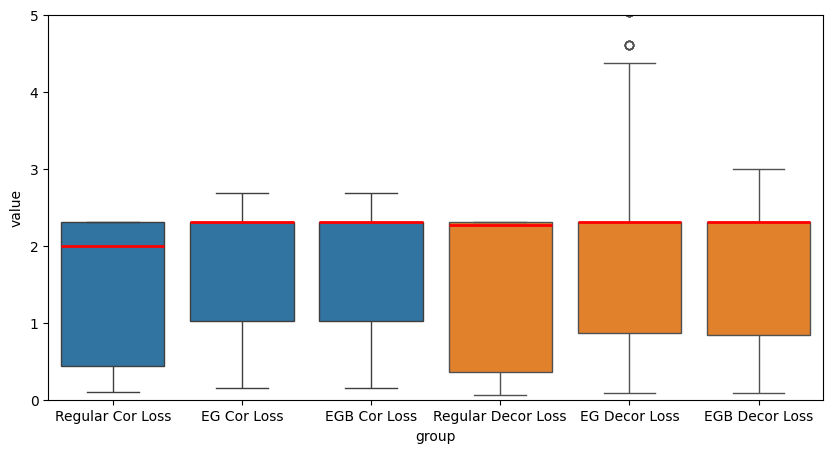

In [22]:
# Combine into a DataFrame
df_cor_loss = pd.DataFrame({
    "value": R_cor_loss + EG_cor_loss+ EGB_cor_loss,
    "group": ["Regular Cor Loss"] * len(R_cor_loss) + ["EG Cor Loss"] * len(EG_cor_loss) + ["EGB Cor Loss"] * len(EGB_cor_loss)
})

df_decor_loss = pd.DataFrame({
    "value": R_decor_loss + EG_decor_loss+ EGB_decor_loss,
    "group": ["Regular Decor Loss"] * len(R_decor_loss) + ["EG Decor Loss"] * len(EG_decor_loss) + ["EGB Decor Loss"] * len(EGB_decor_loss)
})




# Create box plot
plt.figure(figsize=(10, 5)) 
sns.boxplot(x="group", y="value", data=df_cor_loss, medianprops=dict(color="red", linewidth=2))
sns.boxplot(x="group", y="value", data=df_decor_loss, medianprops=dict(color="red", linewidth=2))

plt.ylim(0, 5)  # Set y-axis limits
plt.show()

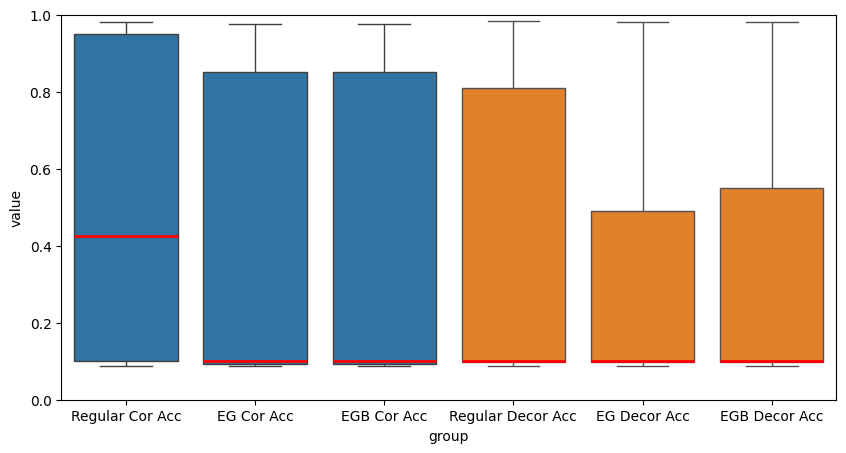

In [23]:
df_cor_acc = pd.DataFrame({
    "value": R_cor_acc + EG_cor_acc+ EGB_cor_acc,
    "group": ["Regular Cor Acc"] * len(R_cor_acc) + ["EG Cor Acc"] * len(EG_cor_acc) + ["EGB Cor Acc"] * len(EGB_cor_acc)
})

df_decor_acc= pd.DataFrame({
    "value": R_decor_acc + EG_decor_acc+ EGB_decor_acc,
    "group": ["Regular Decor Acc"] * len(R_decor_acc) + ["EG Decor Acc"] * len(EG_decor_acc) + ["EGB Decor Acc"] * len(EGB_decor_acc)
})

plt.figure(figsize=(10, 5)) 
sns.boxplot(x="group", y="value", data=df_cor_acc, medianprops=dict(color="red", linewidth=2))
sns.boxplot(x="group", y="value", data=df_decor_acc, medianprops=dict(color="red", linewidth=2))

plt.ylim(0, 1)  # Set y-axis limits
plt.show()

In [24]:
# Create output directory
location = "results testset"
os.makedirs(f"./{location}/Graphs", exist_ok=True)

model_dir = [f"./{location}/1", f"./{location}/22", f"./{location}/42"]
all_figures = []
data1 = []
data22 = []
data42 = []
j=0
for dir in model_dir:
    #print(f"Processing: {dir}")
    for fname in sorted(os.listdir(dir)):
        
        if fname.endswith(".pt"):
            #print("pt")
            fpath = os.path.join(dir, fname)

            #print(f"Processing {fname}...")
            d1 = torch.load(fpath, map_location='cpu', weights_only=False)
            pattern = r"-(KMNIST|MNIST)-([a-z]+)-"
            match = re.search(pattern, fname, re.IGNORECASE)
            if match:
                prefix = match.group(1).lower()
                type = match.group(2).lower()
                #print(dataset, prefix)

            stats = d1.get("stats")
            lr = d1.get("learning_rate")
            dlr = d1.get("decor_learning_rate")
            decay = d1.get("decay")

            totalLoss = 0
            for i in range(len(stats[4])):
                totalLoss+=stats[4][i]

            if(j==0):
                #print("1")
                data1.append({"name": fname, "dataset": prefix, "type": type, "val_loss":stats[4][49], "learning_rate": lr, "decor_learning_rate": dlr, "val_accuracy": stats[5][49], "decay": decay, "totalLoss": totalLoss/50})
            elif(j==1):
                #print("2")
                data22.append({"name": fname, "dataset": prefix, "type": type, "val_loss":stats[4][49], "learning_rate": lr, "decor_learning_rate": dlr, "val_accuracy": stats[5][49], "decay": decay, "totalLoss": totalLoss/50})
            elif(j==2):
               # print("3")
                data42.append({"name": fname, "dataset": prefix, "type": type, "val_loss":stats[4][49], "learning_rate": lr, "decor_learning_rate": dlr, "val_accuracy": stats[5][49], "decay": decay, "totalLoss": totalLoss/50})

    j+=1
df1 = pd.DataFrame(data1)
df1.to_excel(f"./{location}/data1.xlsx")

merged_data = []

# Assuming all three lists have the same length and same ordering
for d1, d2, d3 in zip(data1, data22, data42):
    merged_data.append({
        "name": d1["name"],  # assuming they are the same
        "dataset": d1["dataset"],
        "type": d1["type"],
        "learning_rate": d1["learning_rate"],
        "decor_learning_rate": d1["decor_learning_rate"],
        "decay": d1["decay"],
        "val_loss": (d1["val_loss"] + d2["val_loss"] + d3["val_loss"]) / 3,
        "val_accuracy": (d1["val_accuracy"] + d2["val_accuracy"] + d3["val_accuracy"]) / 3,
        "totalLoss": (d1["totalLoss"] + d2["totalLoss"] + d3["totalLoss"]) / 3
    })

df = pd.DataFrame(merged_data)
df.to_excel(f"./{location}/df.xlsx")

def row_as_dict(df_slice: pd.DataFrame) -> dict:
    """
    Convert a 1-row filtered DataFrame to a dict of scalars.
    Learning rates will be formatted in compact scientific notation (1e-04 style).
    """
    if isinstance(df_slice, pd.Series):
        row_dict = df_slice.to_dict()
    elif isinstance(df_slice, pd.DataFrame):
        if df_slice.empty:
            raise ValueError("row_as_dict: the filtered DataFrame is empty (no matching row).")
        if len(df_slice) > 1:
            df_slice = df_slice.iloc[[0]]
        row_dict = df_slice.iloc[0].to_dict()
    else:
        raise TypeError(f"row_as_dict expects a DataFrame/Series, got {type(df_slice)}")

    # Compact scientific notation for learning rate (e.g., 1e-04 instead of 1.000000e-04)
    if "learning_rate" in row_dict:
        try:
            lr = float(row_dict["learning_rate"])
            row_dict["learning_rate"] = f"{lr:.0e}"  # no decimal part
        except ValueError:
            pass

    return row_dict

###################GD######################

R_best_acc_params_reg[0] = row_as_dict(df[df["name"] == "GD-best-acc-MNIST-decor-1.pt"])
R_best_loss_params_reg[0] = row_as_dict(df[df["name"] == "GD-best-loss-MNIST-decor-1.pt"])
R_best_total_loss_params_reg[0] = row_as_dict(df[df["name"] == "GD-best-avgloss-MNIST-decor-1.pt"])
R_best_acc_params_k[0] = row_as_dict(df[df["name"] == "GD-best-acc-KMNIST-decor-1.pt"])
R_best_loss_params_k[0] = row_as_dict(df[df["name"] == "GD-best-loss-KMNIST-decor-1.pt"])
R_best_total_loss_params_k[0] = row_as_dict(df[df["name"] == "GD-best-avgloss-KMNIST-decor-1.pt"])

print("###########################################################################################")

R_cor_best_acc_params_reg[0] = row_as_dict(df[df["name"] == "GD-best-acc-MNIST-cor-1.pt"])
R_cor_best_loss_params_reg[0] = row_as_dict(df[df["name"] == "GD-best-loss-MNIST-cor-1.pt"])
R_cor_best_total_loss_params_reg[0] = row_as_dict(df[df["name"] == "GD-best-avgloss-MNIST-cor-1.pt"])
R_cor_best_acc_params_k[0] = row_as_dict(df[df["name"] == "GD-best-acc-KMNIST-cor-1.pt"])
R_cor_best_loss_params_k[0] = row_as_dict(df[df["name"] == "GD-best-loss-KMNIST-cor-1.pt"])
R_cor_best_total_loss_params_k[0] = row_as_dict(df[df["name"] == "GD-best-avgloss-KMNIST-cor-1.pt"])

#########################EG######################
EG_best_acc_params_reg[0] = row_as_dict(df[df["name"] == "EG-best-acc-MNIST-decor-1.pt"])
EG_best_loss_params_reg[0] = row_as_dict(df[df["name"] == "EG-best-loss-MNIST-decor-1.pt"])
EG_best_total_loss_params_reg[0] = row_as_dict(df[df["name"] == "EG-best-avgloss-MNIST-decor-1.pt"])
EG_best_acc_params_k[0] = row_as_dict(df[df["name"] == "EG-best-acc-KMNIST-decor-1.pt"])
EG_best_loss_params_k[0] = row_as_dict(df[df["name"] == "EG-best-loss-KMNIST-decor-1.pt"])
EG_best_total_loss_params_k[0] = row_as_dict(df[df["name"] == "EG-best-avgloss-KMNIST-decor-1.pt"])

print("###########################################################################################")

EG_cor_best_acc_params_reg[0] = row_as_dict(df[df["name"] == "EG-best-acc-MNIST-cor-1.pt"])
EG_cor_best_loss_params_reg[0] = row_as_dict(df[df["name"] == "EG-best-loss-MNIST-cor-1.pt"])
EG_cor_best_total_loss_params_reg[0] = row_as_dict(df[df["name"] == "EG-best-avgloss-MNIST-cor-1.pt"])
EG_cor_best_acc_params_k[0] = row_as_dict(df[df["name"] == "EG-best-acc-KMNIST-cor-1.pt"])
EG_cor_best_loss_params_k[0] = row_as_dict(df[df["name"] == "EG-best-loss-KMNIST-cor-1.pt"])
EG_cor_best_total_loss_params_k[0] = row_as_dict(df[df["name"] == "EG-best-avgloss-KMNIST-cor-1.pt"])

########################EGB#######################
EGB_best_acc_params_reg[0] = row_as_dict(df[df["name"] == "EGB-best-acc-MNIST-decor-1.pt"])
EGB_best_loss_params_reg[0] = row_as_dict(df[df["name"] == "EGB-best-loss-MNIST-decor-1.pt"])
EGB_best_total_loss_params_reg[0] = row_as_dict(df[df["name"] == "EGB-best-avgloss-MNIST-decor-1.pt"])
EGB_best_acc_params_k[0] = row_as_dict(df[df["name"] == "EGB-best-acc-KMNIST-decor-1.pt"])
EGB_best_loss_params_k[0] = row_as_dict(df[df["name"] == "EGB-best-loss-KMNIST-decor-1.pt"])
EGB_best_total_loss_params_k[0] = row_as_dict(df[df["name"] == "EGB-best-avgloss-KMNIST-decor-1.pt"])

print("###########################################################################################")

EGB_cor_best_acc_params_reg[0] = row_as_dict(df[df["name"] == "EGB-best-acc-MNIST-cor-1.pt"])
EGB_cor_best_loss_params_reg[0] = row_as_dict(df[df["name"] == "EGB-best-loss-MNIST-cor-1.pt"])
EGB_cor_best_total_loss_params_reg[0] = row_as_dict(df[df["name"] == "EGB-best-avgloss-MNIST-cor-1.pt"])
EGB_cor_best_acc_params_k[0] = row_as_dict(df[df["name"] == "EGB-best-acc-KMNIST-cor-1.pt"])
EGB_cor_best_loss_params_k[0] = row_as_dict(df[df["name"] == "EGB-best-loss-KMNIST-cor-1.pt"])
EGB_cor_best_total_loss_params_k[0] = row_as_dict(df[df["name"] == "EGB-best-avgloss-KMNIST-cor-1.pt"])



###########################################################################################
###########################################################################################
###########################################################################################


In [25]:
#test = (df[df["name"] == "EG-best-acc-KMNIST-cor-1.pt"])
print(R_best_acc_params_reg[0])

{'name': 'GD-best-acc-MNIST-decor-1.pt', 'dataset': 'mnist', 'type': 'decor', 'learning_rate': '1e-04', 'decor_learning_rate': 1e-10, 'decay': 0.0, 'val_loss': 0.10453310974398257, 'val_accuracy': 0.9833333333333334, 'totalLoss': 0.09090775198494432}


C:\Users\teowe\AppData\Local\Temp\ipykernel_24408\2730735384.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Accuracy"])
C:\Users\teowe\AppData\Local\Temp\ipykernel_24408\2730735384.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Accuracy"])


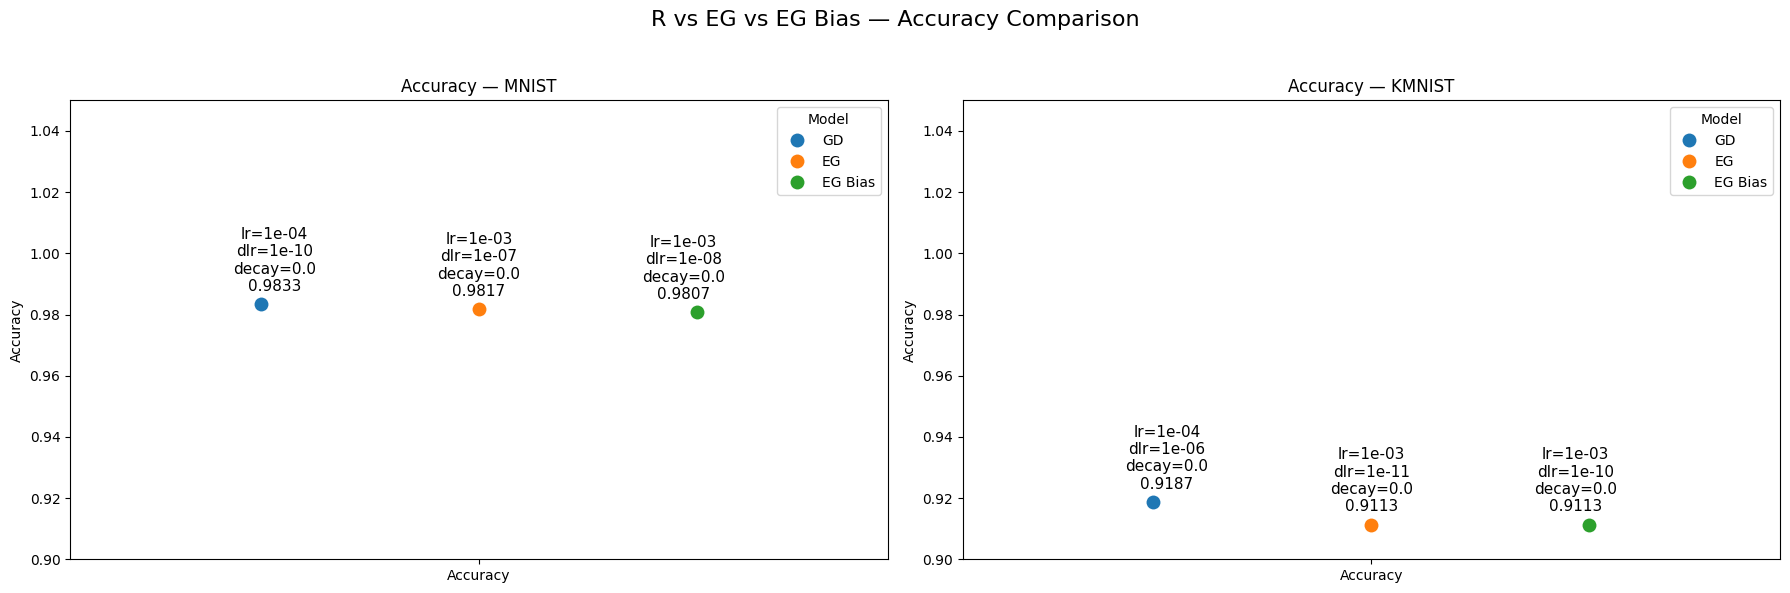

C:\Users\teowe\AppData\Local\Temp\ipykernel_24408\2730735384.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes2[1].legend(title="Model")


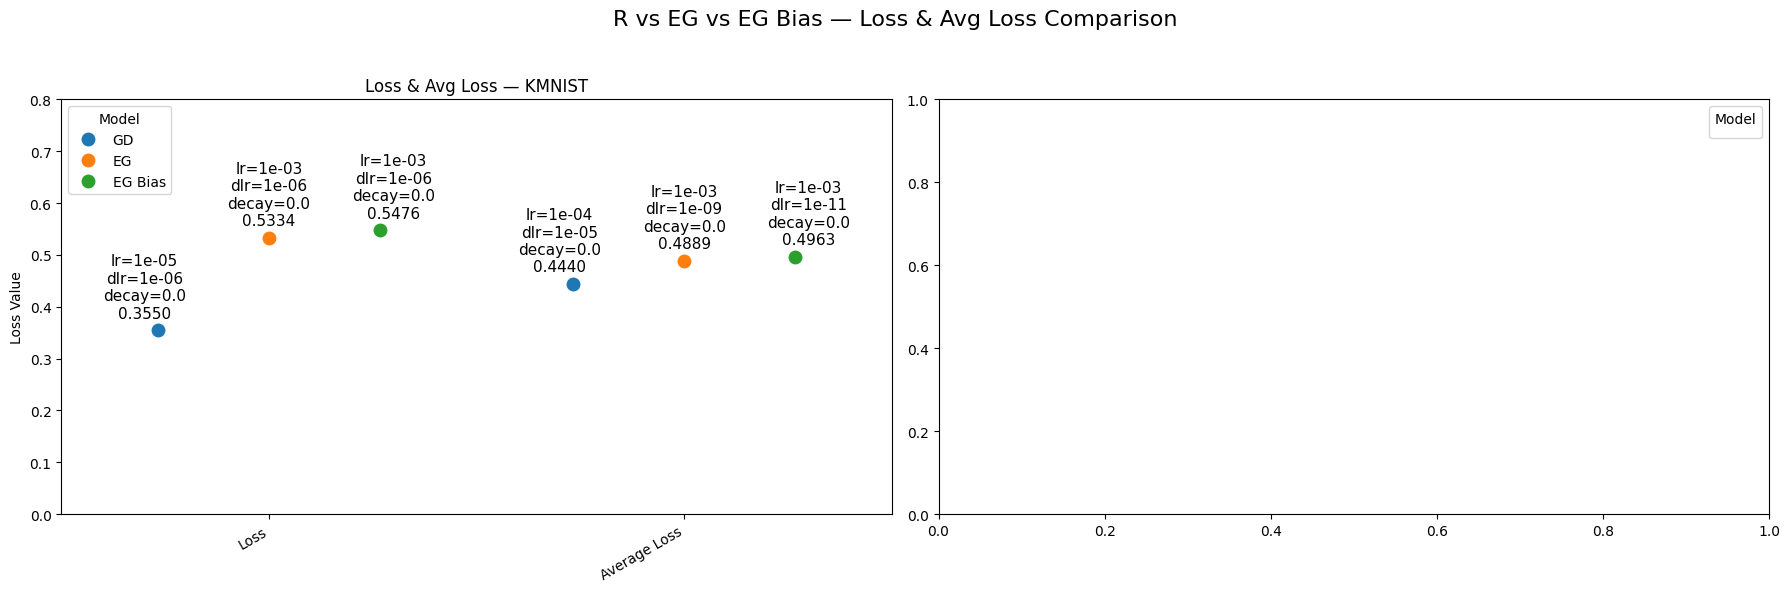

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# === Build Data ===
data = []

def add_rows(metric_name, dataset_name, R, EG, EGB, key):
    data.append((
        metric_name, dataset_name, "GD", R[key],
        R["learning_rate"], R["decor_learning_rate"], R["decay"]
    ))
    data.append((
        metric_name, dataset_name, "EG", EG[key],
        EG["learning_rate"], EG["decor_learning_rate"], EG["decay"]
    ))
    data.append((
        metric_name, dataset_name, "EG Bias", EGB[key],
        EGB["learning_rate"], EGB["decor_learning_rate"], EGB["decay"]
    ))

# === Add rows for MNIST ===
add_rows("Accuracy", "MNIST", R_best_acc_params_reg[0], EG_best_acc_params_reg[0], EGB_best_acc_params_reg[0], "val_accuracy")
add_rows("Loss", "MNIST", R_best_loss_params_reg[0], EG_best_loss_params_reg[0], EGB_best_loss_params_reg[0], "val_loss")
add_rows("Average Loss", "MNIST", R_best_total_loss_params_reg[0], EG_best_total_loss_params_reg[0], EGB_best_total_loss_params_reg[0], "totalLoss")

# === Add rows for KMNIST ===
add_rows("Accuracy", "KMNIST", R_best_acc_params_k[0], EG_best_acc_params_k[0], EGB_best_acc_params_k[0], "val_accuracy")
add_rows("Loss", "KMNIST", R_best_loss_params_k[0], EG_best_loss_params_k[0], EGB_best_loss_params_k[0], "val_loss")
add_rows("Average Loss", "KMNIST", R_best_total_loss_params_k[0], EG_best_total_loss_params_k[0], EGB_best_total_loss_params_k[0], "totalLoss")

# === DataFrame ===
df_all = pd.DataFrame(data, columns=[
    "Metric", "Dataset", "Model", "Value",
    "Learning Rate", "Decor Learning Rate", "Decay"
])
df_all["MetricGroup"] = df_all["Metric"] + " (" + df_all["Dataset"] + ")"

# === Split data ===
df_acc = df_all[df_all["Metric"] == "Accuracy"]
df_loss = df_all[df_all["Metric"].isin(["Loss", "Average Loss"])]

# === Plot 1: Accuracy ===
fig1, axes1 = plt.subplots(1, 2, figsize=(18, 6))
for i, dataset in enumerate(["MNIST", "KMNIST"]):
    df_subset = df_acc[df_acc["Dataset"] == dataset]
    ax = axes1[i]

    sns.stripplot(data=df_subset, x="Metric", y="Value", hue="Model", size=10, jitter=False, dodge=True, ax=ax)

    for _, row in df_subset.iterrows():
        x_offset = {"GD": -0.25, "EG": 0.0, "EG Bias": 0.25}[row["Model"]]
        y_offset = 0.02 * (df_all["Value"].max() - df_all["Value"].min())-0.015
        label = (
            f"lr={row['Learning Rate']}\n"
            f"dlr={row['Decor Learning Rate']}\n"
            f"decay={row['Decay']}\n"
            f"{row['Value']:.4f}"
        )
        ax.text(
            x=0 + x_offset,  # only one metric: "Accuracy"
            y=row["Value"] + y_offset,
            s=label,
            ha='center', va='bottom', fontsize=11
        )

    ax.set_title(f"Accuracy — {dataset}")
    ax.set_ylabel("Accuracy")
    ax.set_ylim(0.9, 1.05)
    ax.set_xlabel("")
    ax.set_xticklabels(["Accuracy"])

fig1.suptitle("R vs EG vs EG Bias — Accuracy Comparison", fontsize=16)
fig1.tight_layout(rect=[0, 0, 1, 0.95])
axes1[1].legend(title="Model")
plt.show()

# === Plot 2: Loss & Average Loss ===
fig2, axes2 = plt.subplots(1, 2, figsize=(18, 6))
for i, dataset in enumerate(["KMNIST"]):
    df_subset = df_loss[df_loss["Dataset"] == dataset]
    ax = axes2[i]

    sns.stripplot(data=df_subset, x="Metric", y="Value", hue="Model", size=10, jitter=False, dodge=True, ax=ax)

    x_labels = list(df_subset["Metric"].unique())
    for _, row in df_subset.iterrows():
        x_pos = x_labels.index(row["Metric"])
        x_offset = {"GD": -0.3, "EG": 0.0, "EG Bias": 0.3}[row["Model"]]
        y_offset = 0.02 * (df_all["Value"].max() - df_all["Value"].min())
        label = (
            f"lr={row['Learning Rate']}\n"
            f"dlr={row['Decor Learning Rate']}\n"
            f"decay={row['Decay']}\n"
            f"{row['Value']:.4f}"
        )
        ax.text(
            x=x_pos + x_offset,
            y=row["Value"] + y_offset,
            s=label,
            ha='center', va='bottom', fontsize=11
        )

    ax.set_title(f"Loss & Avg Loss — {dataset}")
    ax.set_ylabel("Loss Value")
    ax.set_ylim(0, 0.8)
    ax.set_xlabel("")
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=30, ha='right')

fig2.suptitle("R vs EG vs EG Bias — Loss & Avg Loss Comparison", fontsize=16)
fig2.tight_layout(rect=[0, 0, 1, 0.95])
axes2[1].legend(title="Model")
plt.show()

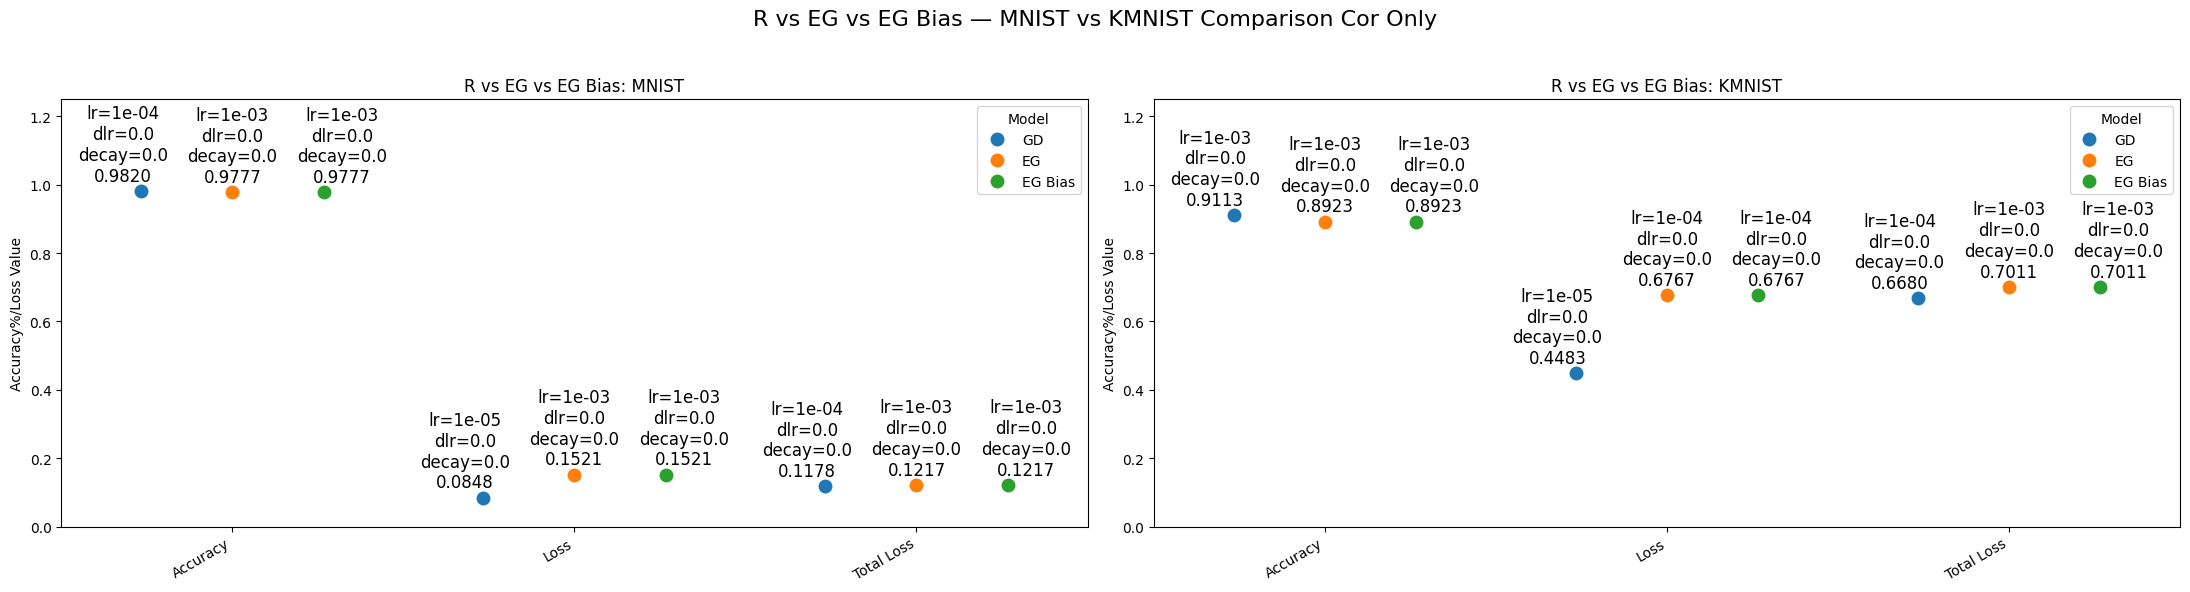

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# === Build Data ===
data = []

def add_rows(metric_name, dataset_name, R, EG, EGB, key):
    data.append((
        metric_name, dataset_name, "GD", R[key],
        R["learning_rate"], R["decor_learning_rate"], R["decay"]
    ))
    data.append((
        metric_name, dataset_name, "EG", EG[key],
        EG["learning_rate"], EG["decor_learning_rate"], EG["decay"]
    ))
    data.append((
        metric_name, dataset_name, "EG Bias", EGB[key],
        EGB["learning_rate"], EGB["decor_learning_rate"], EGB["decay"]
    ))
        
# === Add rows for MNIST ===
add_rows("Accuracy", "MNIST", R_cor_best_acc_params_reg[0], EG_cor_best_acc_params_reg[0], EGB_cor_best_acc_params_reg[0], "val_accuracy")
add_rows("Loss", "MNIST", R_cor_best_loss_params_reg[0], EG_cor_best_loss_params_reg[0], EGB_cor_best_loss_params_reg[0], "val_loss")
add_rows("Total Loss", "MNIST", R_cor_best_total_loss_params_reg[0], EG_cor_best_total_loss_params_reg[0], EGB_cor_best_total_loss_params_reg[0], "totalLoss")

# === Add rows for KMNIST ===
add_rows("Accuracy", "KMNIST", R_cor_best_acc_params_k[0], EG_cor_best_acc_params_k[0], EGB_cor_best_acc_params_k[0], "val_accuracy")
add_rows("Loss", "KMNIST", R_cor_best_loss_params_k[0], EG_cor_best_loss_params_k[0], EGB_cor_best_loss_params_k[0], "val_loss")
add_rows("Total Loss", "KMNIST", R_cor_best_total_loss_params_k[0], EG_cor_best_total_loss_params_k[0], EGB_cor_best_total_loss_params_k[0], "totalLoss")

# === DataFrame ===
df_all = pd.DataFrame(data, columns=[
    "Metric", "Dataset", "Model", "Value",
    "Learning Rate", "Decor Learning Rate", "Decay"
])
df_all["MetricGroup"] = df_all["Metric"] + " (" + df_all["Dataset"] + ")"

# === Plotting ===
fig, axes = plt.subplots(1, 2, figsize=(22, 6))

for i, dataset in enumerate(["MNIST", "KMNIST"]):
    df_subset = df_all[df_all["Dataset"] == dataset]
    ax = axes[i]
    
    sns.stripplot(data=df_subset, x="Metric", y="Value", hue="Model", size=10, jitter=False, dodge=True, ax=ax)
    
    x_labels = list(df_subset["Metric"].unique())
    for _, row in df_subset.iterrows():
        x_pos = x_labels.index(row["Metric"])
        x_offset = {"GD": -0.32, "EG": 0.0, "EG Bias": 0.32}[row["Model"]]
        y_offset = 0.02 * (df_all["Value"].max() - df_all["Value"].min())

        label = (
            f"lr={row['Learning Rate']}\n"
            f"dlr={row['Decor Learning Rate']}\n"
            f"decay={row['Decay']}\n"
            f"{row['Value']:.4f}"
        )

        ax.text(
            x=x_pos + x_offset,
            y=row["Value"] + y_offset,
            s=label,
            ha='center',
            va='bottom',
            fontsize=12
        )

    ax.set_title(f"R vs EG vs EG Bias: {dataset}")
    ax.set_xlabel("")
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=30, ha='right')
    ax.set_ylabel("Accuracy%/Loss Value")
    ax.set_ylim(0, 1.25)

# Final touches
fig.suptitle("R vs EG vs EG Bias — MNIST vs KMNIST Comparison Cor Only", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
axes[1].legend(title="Model")  # Put legend on second plot
plt.show()


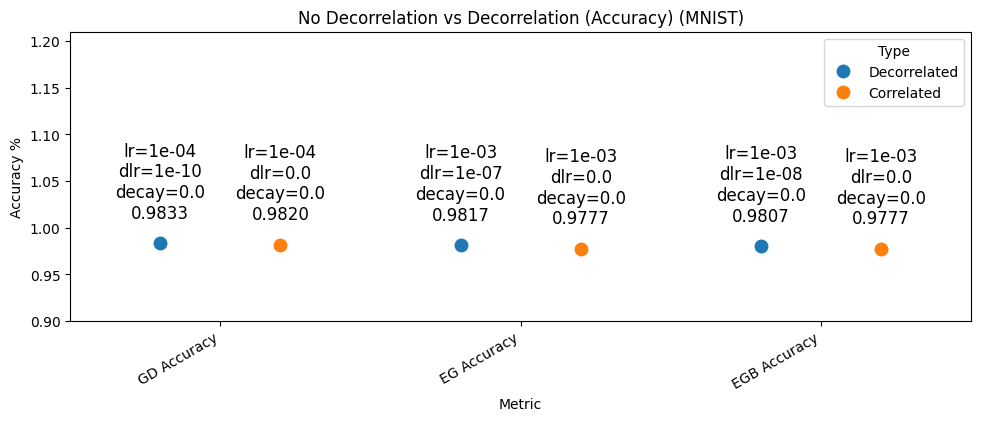

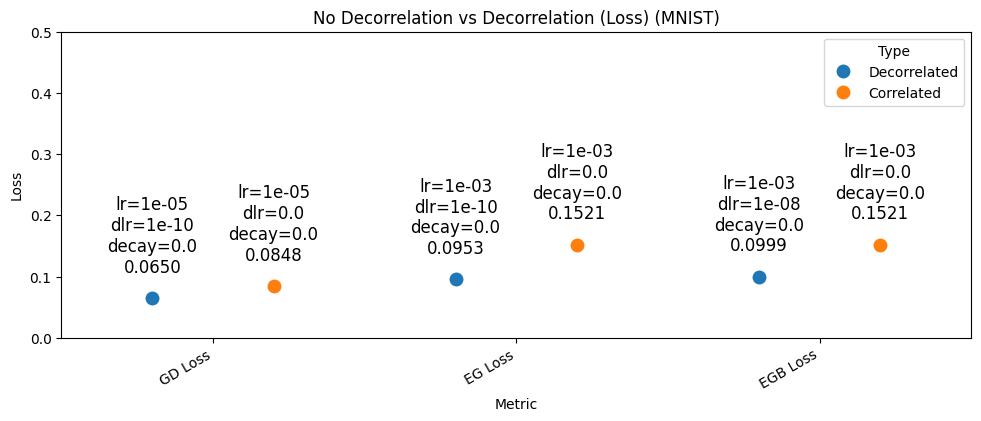

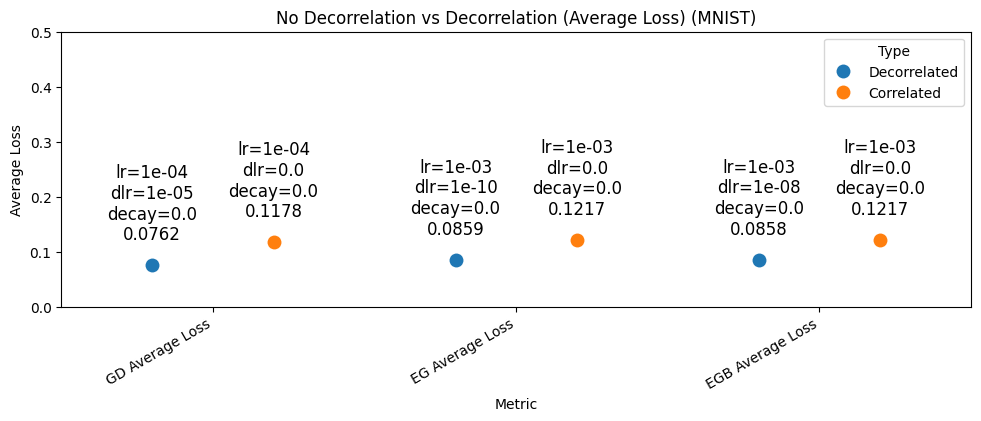

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = []

# Regular
data += [("GD Accuracy", "Decorrelated", R_best_acc_params_reg[0]["val_accuracy"],
          R_best_acc_params_reg[0]["learning_rate"], R_best_acc_params_reg[0]["decor_learning_rate"], R_best_acc_params_reg[0]["decay"])]
data += [("GD Accuracy", "Correlated", R_cor_best_acc_params_reg[0]["val_accuracy"],
          R_cor_best_acc_params_reg[0]["learning_rate"], 0.0, R_cor_best_acc_params_reg[0]["decay"])]

data += [("GD Loss", "Decorrelated", R_best_loss_params_reg[0]["val_loss"],
          R_best_loss_params_reg[0]["learning_rate"], R_best_loss_params_reg[0]["decor_learning_rate"], R_best_loss_params_reg[0]["decay"])]
data += [("GD Loss", "Correlated", R_cor_best_loss_params_reg[0]["val_loss"],
          R_cor_best_loss_params_reg[0]["learning_rate"], 0.0, R_cor_best_loss_params_reg[0]["decay"])]

data += [("GD Average Loss", "Decorrelated", R_best_total_loss_params_reg[0]["totalLoss"],
          R_best_total_loss_params_reg[0]["learning_rate"], R_best_total_loss_params_reg[0]["decor_learning_rate"], R_best_total_loss_params_reg[0]["decay"])]
data += [("GD Average Loss", "Correlated", R_cor_best_total_loss_params_reg[0]["totalLoss"],
          R_cor_best_total_loss_params_reg[0]["learning_rate"], 0.0, R_cor_best_total_loss_params_reg[0]["decay"])]

# EG
data += [("EG Accuracy", "Decorrelated", EG_best_acc_params_reg[0]["val_accuracy"],
          EG_best_acc_params_reg[0]["learning_rate"], EG_best_acc_params_reg[0]["decor_learning_rate"], EG_best_acc_params_reg[0]["decay"])]
data += [("EG Accuracy", "Correlated", EG_cor_best_acc_params_reg[0]["val_accuracy"],
          EG_cor_best_acc_params_reg[0]["learning_rate"], 0.0, EG_cor_best_acc_params_reg[0]["decay"])]

data += [("EG Loss", "Decorrelated", EG_best_loss_params_reg[0]["val_loss"],
          EG_best_loss_params_reg[0]["learning_rate"], EG_best_loss_params_reg[0]["decor_learning_rate"], EG_best_loss_params_reg[0]["decay"])]
data += [("EG Loss", "Correlated", EG_cor_best_loss_params_reg[0]["val_loss"],
          EG_cor_best_loss_params_reg[0]["learning_rate"], 0.0, EG_cor_best_loss_params_reg[0]["decay"])]

data += [("EG Average Loss", "Decorrelated", EG_best_total_loss_params_reg[0]["totalLoss"],
          EG_best_total_loss_params_reg[0]["learning_rate"], EG_best_total_loss_params_reg[0]["decor_learning_rate"], EG_best_total_loss_params_reg[0]["decay"])]
data += [("EG Average Loss", "Correlated", EG_cor_best_total_loss_params_reg[0]["totalLoss"],
          EG_cor_best_total_loss_params_reg[0]["learning_rate"], 0.0, EG_cor_best_total_loss_params_reg[0]["decay"])]

# EGB
data += [("EGB Accuracy", "Decorrelated", EGB_best_acc_params_reg[0]["val_accuracy"],
          EGB_best_acc_params_reg[0]["learning_rate"], EGB_best_acc_params_reg[0]["decor_learning_rate"], EGB_best_acc_params_reg[0]["decay"])]
data += [("EGB Accuracy", "Correlated", EGB_cor_best_acc_params_reg[0]["val_accuracy"],
          EGB_cor_best_acc_params_reg[0]["learning_rate"], 0.0, EGB_cor_best_acc_params_reg[0]["decay"])]

data += [("EGB Loss", "Decorrelated", EGB_best_loss_params_reg[0]["val_loss"],
          EGB_best_loss_params_reg[0]["learning_rate"], EGB_best_loss_params_reg[0]["decor_learning_rate"], EGB_best_loss_params_reg[0]["decay"])]
data += [("EGB Loss", "Correlated", EGB_cor_best_loss_params_reg[0]["val_loss"],
          EGB_cor_best_loss_params_reg[0]["learning_rate"], 0.0, EGB_cor_best_loss_params_reg[0]["decay"])]

data += [("EGB Average Loss", "Decorrelated", EGB_best_total_loss_params_reg[0]["totalLoss"],
          EGB_best_total_loss_params_reg[0]["learning_rate"], EGB_best_total_loss_params_reg[0]["decor_learning_rate"], EGB_best_total_loss_params_reg[0]["decay"])]
data += [("EGB Average Loss", "Correlated", EGB_cor_best_total_loss_params_reg[0]["totalLoss"],
          EGB_cor_best_total_loss_params_reg[0]["learning_rate"], 0.0, EGB_cor_best_total_loss_params_reg[0]["decay"])]



# Build DataFrame
df_all = pd.DataFrame(data, columns=[
    "Metric", "Correlation", "Value", "Learning Rate", "Decor Learning Rate", "Decay"
])


# --- Split datasets ---
# Split into three DataFrames
df_acc = df_all[df_all["Metric"].str.contains("Accuracy")]
df_loss = df_all[df_all["Metric"].str.contains("Loss") & ~df_all["Metric"].str.contains("Average")]
df_total_loss = df_all[df_all["Metric"].str.contains("Average Loss")]

# Quick check


def plot_with_annotations(df, title, ymin, ymax, ylabel):
    plt.figure(figsize=(10, 5))
    ax = sns.stripplot(
        data=df,
        x="Metric",
        y="Value",
        hue="Correlation",
        size=10,
        jitter=False,
        dodge=True
    )

    x_labels = list(df["Metric"].unique())

    for i, row in df.iterrows():
        x_pos = x_labels.index(row["Metric"])
        x_offset = -0.2 if row["Correlation"] == "Decorrelated" else 0.2
        y_offset = 0.02 * (df["Value"].max() - df["Value"].min())

        label = (
            f"lr={row['Learning Rate']}\n"
            f"dlr={row['Decor Learning Rate']}\n"
            f"decay={row['Decay']}\n"
            f"{row['Value']:.4f}\n"
            ""
        )

        ax.text(
            x=x_pos + x_offset,
            y=row["Value"] + y_offset,
            s=label,
            ha="center",
            va="bottom",
            fontsize=12
        )

    plt.xticks(rotation=30, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.ylim(ymin, ymax)
    plt.legend(title="Type")
    plt.ylabel(ylabel)
    plt.show()

# --- Plot Accuracy ---
plot_with_annotations(df_acc, "No Decorrelation vs Decorrelation (Accuracy) (MNIST)", 0.9,1.21, "Accuracy %")

# --- Plot Loss ---
plot_with_annotations(df_loss, "No Decorrelation vs Decorrelation (Loss) (MNIST)",0, 0.5, "Loss")

plot_with_annotations(df_total_loss, "No Decorrelation vs Decorrelation (Average Loss) (MNIST)",0, 0.5, "Average Loss")

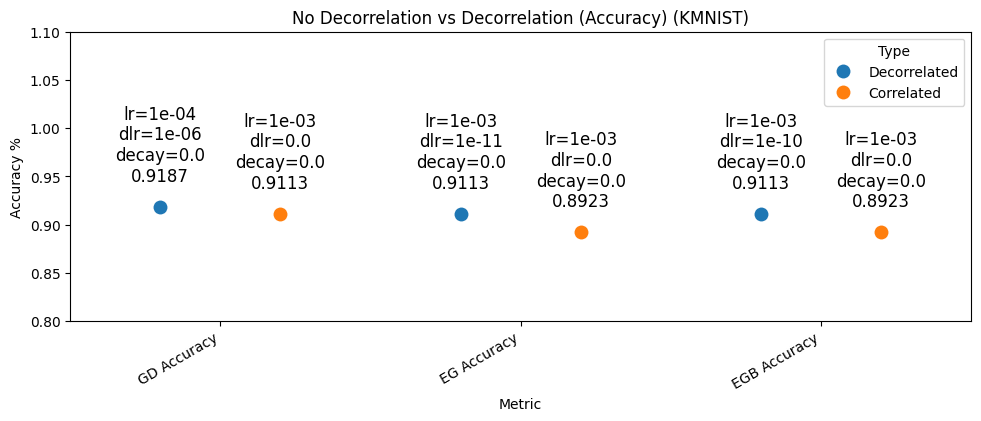

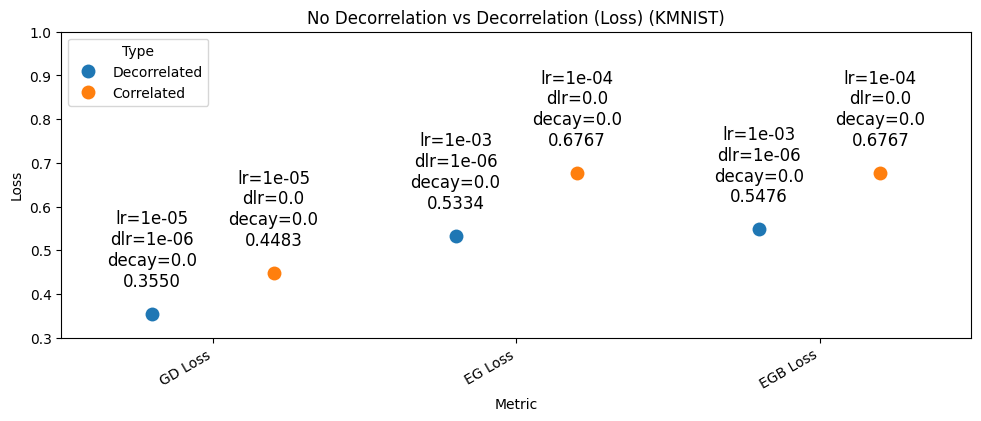

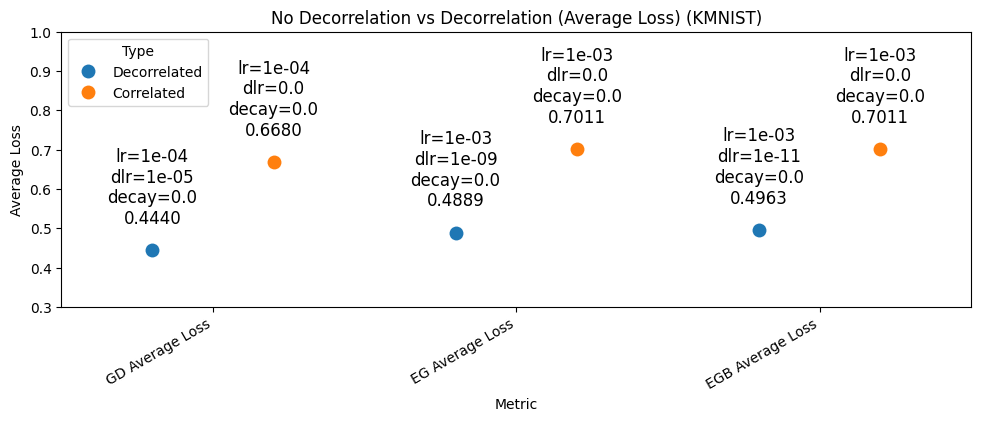

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = []

# Regular
data += [("GD Accuracy", "Decorrelated", R_best_acc_params_k[0]["val_accuracy"],
          R_best_acc_params_k[0]["learning_rate"], R_best_acc_params_k[0]["decor_learning_rate"], R_best_acc_params_k[0]["decay"])]
data += [("GD Accuracy", "Correlated", R_cor_best_acc_params_k[0]["val_accuracy"],
          R_cor_best_acc_params_k[0]["learning_rate"], 0.0, R_cor_best_acc_params_k[0]["decay"])]

data += [("GD Loss", "Decorrelated", R_best_loss_params_k[0]["val_loss"],
          R_best_loss_params_k[0]["learning_rate"], R_best_loss_params_k[0]["decor_learning_rate"], R_best_loss_params_k[0]["decay"])]
data += [("GD Loss", "Correlated", R_cor_best_loss_params_k[0]["val_loss"],
          R_cor_best_loss_params_k[0]["learning_rate"], 0.0, R_cor_best_loss_params_k[0]["decay"])]

data += [("GD Average Loss", "Decorrelated", R_best_total_loss_params_k[0]["totalLoss"],
          R_best_total_loss_params_k[0]["learning_rate"], R_best_total_loss_params_k[0]["decor_learning_rate"], R_best_total_loss_params_k[0]["decay"])]
data += [("GD Average Loss", "Correlated", R_cor_best_total_loss_params_k[0]["totalLoss"],
          R_cor_best_total_loss_params_k[0]["learning_rate"], 0.0, R_cor_best_total_loss_params_k[0]["decay"])]

# EG
data += [("EG Accuracy", "Decorrelated", EG_best_acc_params_k[0]["val_accuracy"],
          EG_best_acc_params_k[0]["learning_rate"], EG_best_acc_params_k[0]["decor_learning_rate"], EG_best_acc_params_k[0]["decay"])]
data += [("EG Accuracy", "Correlated", EG_cor_best_acc_params_k[0]["val_accuracy"],
          EG_cor_best_acc_params_k[0]["learning_rate"], 0.0, EG_cor_best_acc_params_k[0]["decay"])]

data += [("EG Loss", "Decorrelated", EG_best_loss_params_k[0]["val_loss"],
          EG_best_loss_params_k[0]["learning_rate"], EG_best_loss_params_k[0]["decor_learning_rate"], EG_best_loss_params_k[0]["decay"])]
data += [("EG Loss", "Correlated", EG_cor_best_loss_params_k[0]["val_loss"],
          EG_cor_best_loss_params_k[0]["learning_rate"], 0.0, EG_cor_best_loss_params_k[0]["decay"])]

data += [("EG Average Loss", "Decorrelated", EG_best_total_loss_params_k[0]["totalLoss"],
          EG_best_total_loss_params_k[0]["learning_rate"], EG_best_total_loss_params_k[0]["decor_learning_rate"], EG_best_total_loss_params_k[0]["decay"])]
data += [("EG Average Loss", "Correlated", EG_cor_best_total_loss_params_k[0]["totalLoss"],
          EG_cor_best_total_loss_params_k[0]["learning_rate"], 0.0, EG_cor_best_total_loss_params_k[0]["decay"])]

# EGB
data += [("EGB Accuracy", "Decorrelated", EGB_best_acc_params_k[0]["val_accuracy"],
          EGB_best_acc_params_k[0]["learning_rate"], EGB_best_acc_params_k[0]["decor_learning_rate"], EGB_best_acc_params_k[0]["decay"])]
data += [("EGB Accuracy", "Correlated", EGB_cor_best_acc_params_k[0]["val_accuracy"],
          EGB_cor_best_acc_params_k[0]["learning_rate"], 0.0, EGB_cor_best_acc_params_k[0]["decay"])]

data += [("EGB Loss", "Decorrelated", EGB_best_loss_params_k[0]["val_loss"],
          EGB_best_loss_params_k[0]["learning_rate"], EGB_best_loss_params_k[0]["decor_learning_rate"], EGB_best_loss_params_k[0]["decay"])]
data += [("EGB Loss", "Correlated", EGB_cor_best_loss_params_k[0]["val_loss"],
          EGB_cor_best_loss_params_k[0]["learning_rate"], 0.0, EGB_cor_best_loss_params_k[0]["decay"])]

data += [("EGB Average Loss", "Decorrelated", EGB_best_total_loss_params_k[0]["totalLoss"],
          EGB_best_total_loss_params_k[0]["learning_rate"], EGB_best_total_loss_params_k[0]["decor_learning_rate"], EGB_best_total_loss_params_k[0]["decay"])]
data += [("EGB Average Loss", "Correlated", EGB_cor_best_total_loss_params_k[0]["totalLoss"],
          EGB_cor_best_total_loss_params_k[0]["learning_rate"], 0.0, EGB_cor_best_total_loss_params_k[0]["decay"])]



# Build DataFrame
df_all = pd.DataFrame(data, columns=[
    "Metric", "Correlation", "Value", "Learning Rate", "Decor Learning Rate", "Decay"
])


# --- Split datasets ---
# Split into three DataFrames
df_acc = df_all[df_all["Metric"].str.contains("Accuracy")]
df_loss = df_all[df_all["Metric"].str.contains("Loss") & ~df_all["Metric"].str.contains("Average")]
df_total_loss = df_all[df_all["Metric"].str.contains("Average Loss")]

# Quick check


def plot_with_annotations(df, title, ymin, ymax, ylabel):
    plt.figure(figsize=(10, 5))
    ax = sns.stripplot(
        data=df,
        x="Metric",
        y="Value",
        hue="Correlation",
        size=10,
        jitter=False,
        dodge=True
    )

    x_labels = list(df["Metric"].unique())

    for i, row in df.iterrows():
        x_pos = x_labels.index(row["Metric"])
        x_offset = -0.2 if row["Correlation"] == "Decorrelated" else 0.2
        y_offset = 0.02 * (df["Value"].max() - df["Value"].min())

        label = (
            f"lr={row['Learning Rate']}\n"
            f"dlr={row['Decor Learning Rate']}\n"
            f"decay={row['Decay']}\n"
            f"{row['Value']:.4f}\n"
            ""
        )

        ax.text(
            x=x_pos + x_offset,
            y=row["Value"] + y_offset,
            s=label,
            ha="center",
            va="bottom",
            fontsize=12
        )

    plt.xticks(rotation=30, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.ylim(ymin, ymax)
    plt.ylabel(ylabel)
    plt.legend(title="Type")
    plt.show()

# --- Plot Accuracy ---
plot_with_annotations(df_acc, "No Decorrelation vs Decorrelation (Accuracy) (KMNIST)", 0.8,1.1, "Accuracy %")

# --- Plot Loss ---
plot_with_annotations(df_loss, "No Decorrelation vs Decorrelation (Loss) (KMNIST)", 0.3, 1, "Loss")

plot_with_annotations(df_total_loss, "No Decorrelation vs Decorrelation (Average Loss) (KMNIST)",0.3, 1, "Average Loss")


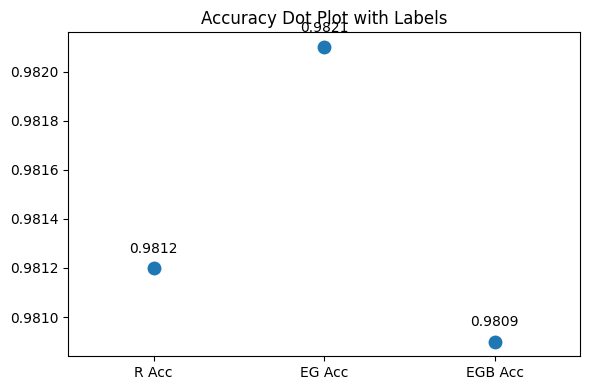

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example data
values = [0.9812, 0.9821, 0.9809]
groups = ["R Acc", "EG Acc", "EGB Acc"]
df = pd.DataFrame({"group": groups, "value": values})

# Create plot
fig, ax = plt.subplots(figsize=(6, 4))
sns.stripplot(x="group", y="value", data=df, size=10, jitter=False, ax=ax)

# Add text labels above each point
for i, row in df.iterrows():
    ax.text(x=i, y=row["value"] + 0.00005, s=f'{row["value"]:.4f}', 
            ha='center', va='bottom', fontsize=10)

# Optional: clean axis
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title("Accuracy Dot Plot with Labels")

plt.tight_layout()
plt.show()


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

def stylized_cov_plot(matrix, ax=None, highlight_blocks=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    # Create the base heatmap
    sns.heatmap(matrix,
                square=True,
                cbar=True,
                xticklabels=False,
                yticklabels=False,
                cmap='magma',  # similar to your uploaded image
                center=0,
                ax=ax,
                cbar_kws={'shrink': 0.6})

    # Add dotted grid lines
    size = matrix.shape[0]
    for i in range(size):
        ax.axhline(i, color='white', linestyle=':', linewidth=0.5)
        ax.axvline(i, color='white', linestyle=':', linewidth=0.5)

    # Optionally add square highlights
    if highlight_blocks:
        for (i, j, block_size) in highlight_blocks:
            rect = plt.Rectangle((j, i), block_size, block_size,
                                 edgecolor='white', facecolor='none', linewidth=2)
            ax.add_patch(rect)

    ax.set_xticks([])
    ax.set_yticks([])

    return ax


In [51]:
import torch
import matplotlib.pyplot as plt
import os
import io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
import matplotlib.colors as mcolors
file_path = './test/EGB acc decor CIFAR correlaton analysis.pt'
d1 = torch.load(file_path, map_location='cpu', weights_only=False)

state_dict= d1.get("state_dict")
hidden_weights = d1.get("hidden_weights")


In [33]:
hidden = torch.cat(hidden_weights[0][0]).float()
print(len(hidden))

10000


In [ ]:
import io
from PIL import Image
def cov_to_corr(cov):
    std_dev = np.sqrt(np.diag(cov))
    denom = np.outer(std_dev, std_dev)
    # Avoid division by zero
    denom[denom == 0] = 1e-10
    return cov / denom

def frob_offdiag(A: np.ndarray) -> float:
    A_off = A.copy()
    np.fill_diagonal(A_off, 0.0)     # zero the diagonal
    return np.linalg.norm(A_off, 'fro')

def cov_matrix(hidden_weights, save):
    cov_list = []

    print(len(hidden_weights[1]))
    length = len(hidden_weights)
    counter=0
    ######initial######
    for i in range(length):
        print("run")
        # save network parameters, losses and accuracy
        X2 = torch.cat(hidden_weights[i][0], dim=0).float() # shape: (n, 10)
        X2_rel = torch.cat(hidden_weights[i][1], dim=0).float() 
        X3 = torch.cat(hidden_weights[i][2], dim=0).float() 
        X3_rel = torch.cat(hidden_weights[i][3], dim=0).float() 
        
        # Center
        X2_centered = (X2 - (X2.mean(dim=0, keepdim=True)))
        #print(X2_centered.shape)
        X2_rel_centered = (X2_rel - (X2_rel.mean(dim=0, keepdim=True)))
        X3_centered = (X3 - (X3.mean(dim=0, keepdim=True)))
        X3_rel_centered = (X3_rel - (X3_rel.mean(dim=0, keepdim=True)))

        # Covariance between X and Y
        x2_cov_matrix = (X2_centered.T @ X2_centered) / (X2.shape[0] - 1)
        x2_rel_cov_matrix = (X2_rel_centered.T @ X2_rel_centered) / (X2_rel.shape[0] - 1)
        x3_cov_matrix = (X3_centered.T @ X3_centered) / (X3.shape[0] - 1)
        x3_rel_cov_matrix = (X3_rel_centered.T @ X3_rel_centered) / (X3_rel.shape[0] - 1)
        
        # Suppose we reshape a 2D matrix into 3D just to simulate slices
        if i == 0:
            name = "initial"
        elif i == 1:
            name = "middle"
        elif i == 2:
            name = "final"  
        # cov_list.append((cov_to_corr(x2_cov_matrix.cpu().numpy()), f"x2_cov_matrix_{name}"))  # convert to numpy
        # cov_list.append((cov_to_corr(x2_rel_cov_matrix.cpu().numpy()), f"x2_rel_cov_matrix_{name}"))  # convert to numpy
        # cov_list.append((cov_to_corr(x3_cov_matrix.cpu().numpy()), f"x3_cov_matrix_{name}"))  # convert to numpy
        # cov_list.append((cov_to_corr(x3_rel_cov_matrix.cpu().numpy()), f"x3_rel_cov_matrix_{name}"))  # convert to numpy

        cov_list.append(((x2_cov_matrix.cpu().numpy()), f"x2_cov_matrix_{name}"))  # convert to numpy
        cov_list.append(((x2_rel_cov_matrix.cpu().numpy()), f"x2_rel_cov_matrix_{name}"))  # convert to numpy
        cov_list.append(((x3_cov_matrix.cpu().numpy()), f"x3_cov_matrix_{name}"))  # convert to numpy
        cov_list.append(((x3_rel_cov_matrix.cpu().numpy()), f"Covariance matrix for GD non-decorrelated MNIST"))  # convert to numpy

     
    
    ##########
    

    # Create 1x4 subplots
    fig, axes = plt.subplots(3, 4, figsize=(24, 24))  # Wider layout for better spacing
    axes = axes.flatten()
    min = [-1, -0.3, -5, -1.5]
    max = [1, 1, 5, 2]
    # Loop through covariance matrices and axes
    for index, (ax, (matrix, name)) in enumerate(zip(axes, cov_list)):
        # Plot heatmap
        #print(index)
        frob = frob_offdiag(matrix)
        print(f"Frobenius norm of {file_path}: {frob:.6f}")
        index = index %4 
        sns.heatmap(matrix,
                    square=True,
                    #cbar=True,
                    xticklabels=False,
                    yticklabels=False,
                    cmap='icefire',
                    center=0,
                    ax=ax,
                    vmin=min[index],
                    vmax=max[index],
                    cbar_kws={'shrink': 0.7, 'label': 'Covariance Value'})

        # g = sns.clustermap(matrix,
        #        method='average',        # linkage method
        #        metric='euclidean',      # distance metric
        #        cmap='coolwarm',
        #        center=0,
        #        vmin=-1, vmax=1,
        #        #ax=ax,
        #        figsize=(10, 10),
        #        xticklabels=False,
        #        yticklabels=False,
        #        dendrogram = "none",
        #        cbar_kws={'label': 'Covariance Value'})
               
        
        # buf = io.BytesIO()
        # g.fig.savefig(buf, format='png', bbox_inches='tight')
        # g.ax_heatmap.collections[0].set_linewidth(0)
        # g.ax_heatmap.collections[0].set_edgecolor('face') 
       
        # buf.seek(0)
        # img = Image.open(buf)
        # Save to Excel
        feature_names = [f"Feature_{i}" for i in range(matrix.shape[0])]
        df_cov = pd.DataFrame(matrix, index=feature_names, columns=feature_names)

        if save:
            df_cov.to_excel(f"/scratch/tcrv4423/covariance/{name}.xlsx")

        # Set title
        plt.suptitle(f"{file_path}")
        ax.set_title(name, pad=10)
        #ax.imshow(img)

    plt.tight_layout()
    plt.show()
    
print(len(hidden_weights))
cov_matrix(hidden_weights, False)


3
Stage 0...
Stage 1...
Stage 2...
Frobenius norm of ./test/EGB acc decor CIFAR correlaton analysis.pt: 65.247284
Frobenius norm of ./test/EGB acc decor CIFAR correlaton analysis.pt: 177.633682
Frobenius norm of ./test/EGB acc decor CIFAR correlaton analysis.pt: 189.158951
Frobenius norm of ./test/EGB acc decor CIFAR correlaton analysis.pt: 1.854386
Frobenius norm of ./test/EGB acc decor CIFAR correlaton analysis.pt: 62.714771
Frobenius norm of ./test/EGB acc decor CIFAR correlaton analysis.pt: 148.581207
Frobenius norm of ./test/EGB acc decor CIFAR correlaton analysis.pt: 153.057831
Frobenius norm of ./test/EGB acc decor CIFAR correlaton analysis.pt: 0.551822
Frobenius norm of ./test/EGB acc decor CIFAR correlaton analysis.pt: 52.284172
Frobenius norm of ./test/EGB acc decor CIFAR correlaton analysis.pt: 112.503639
Frobenius norm of ./test/EGB acc decor CIFAR correlaton analysis.pt: 88.001656
Frobenius norm of ./test/EGB acc decor CIFAR correlaton analysis.pt: 0.278547


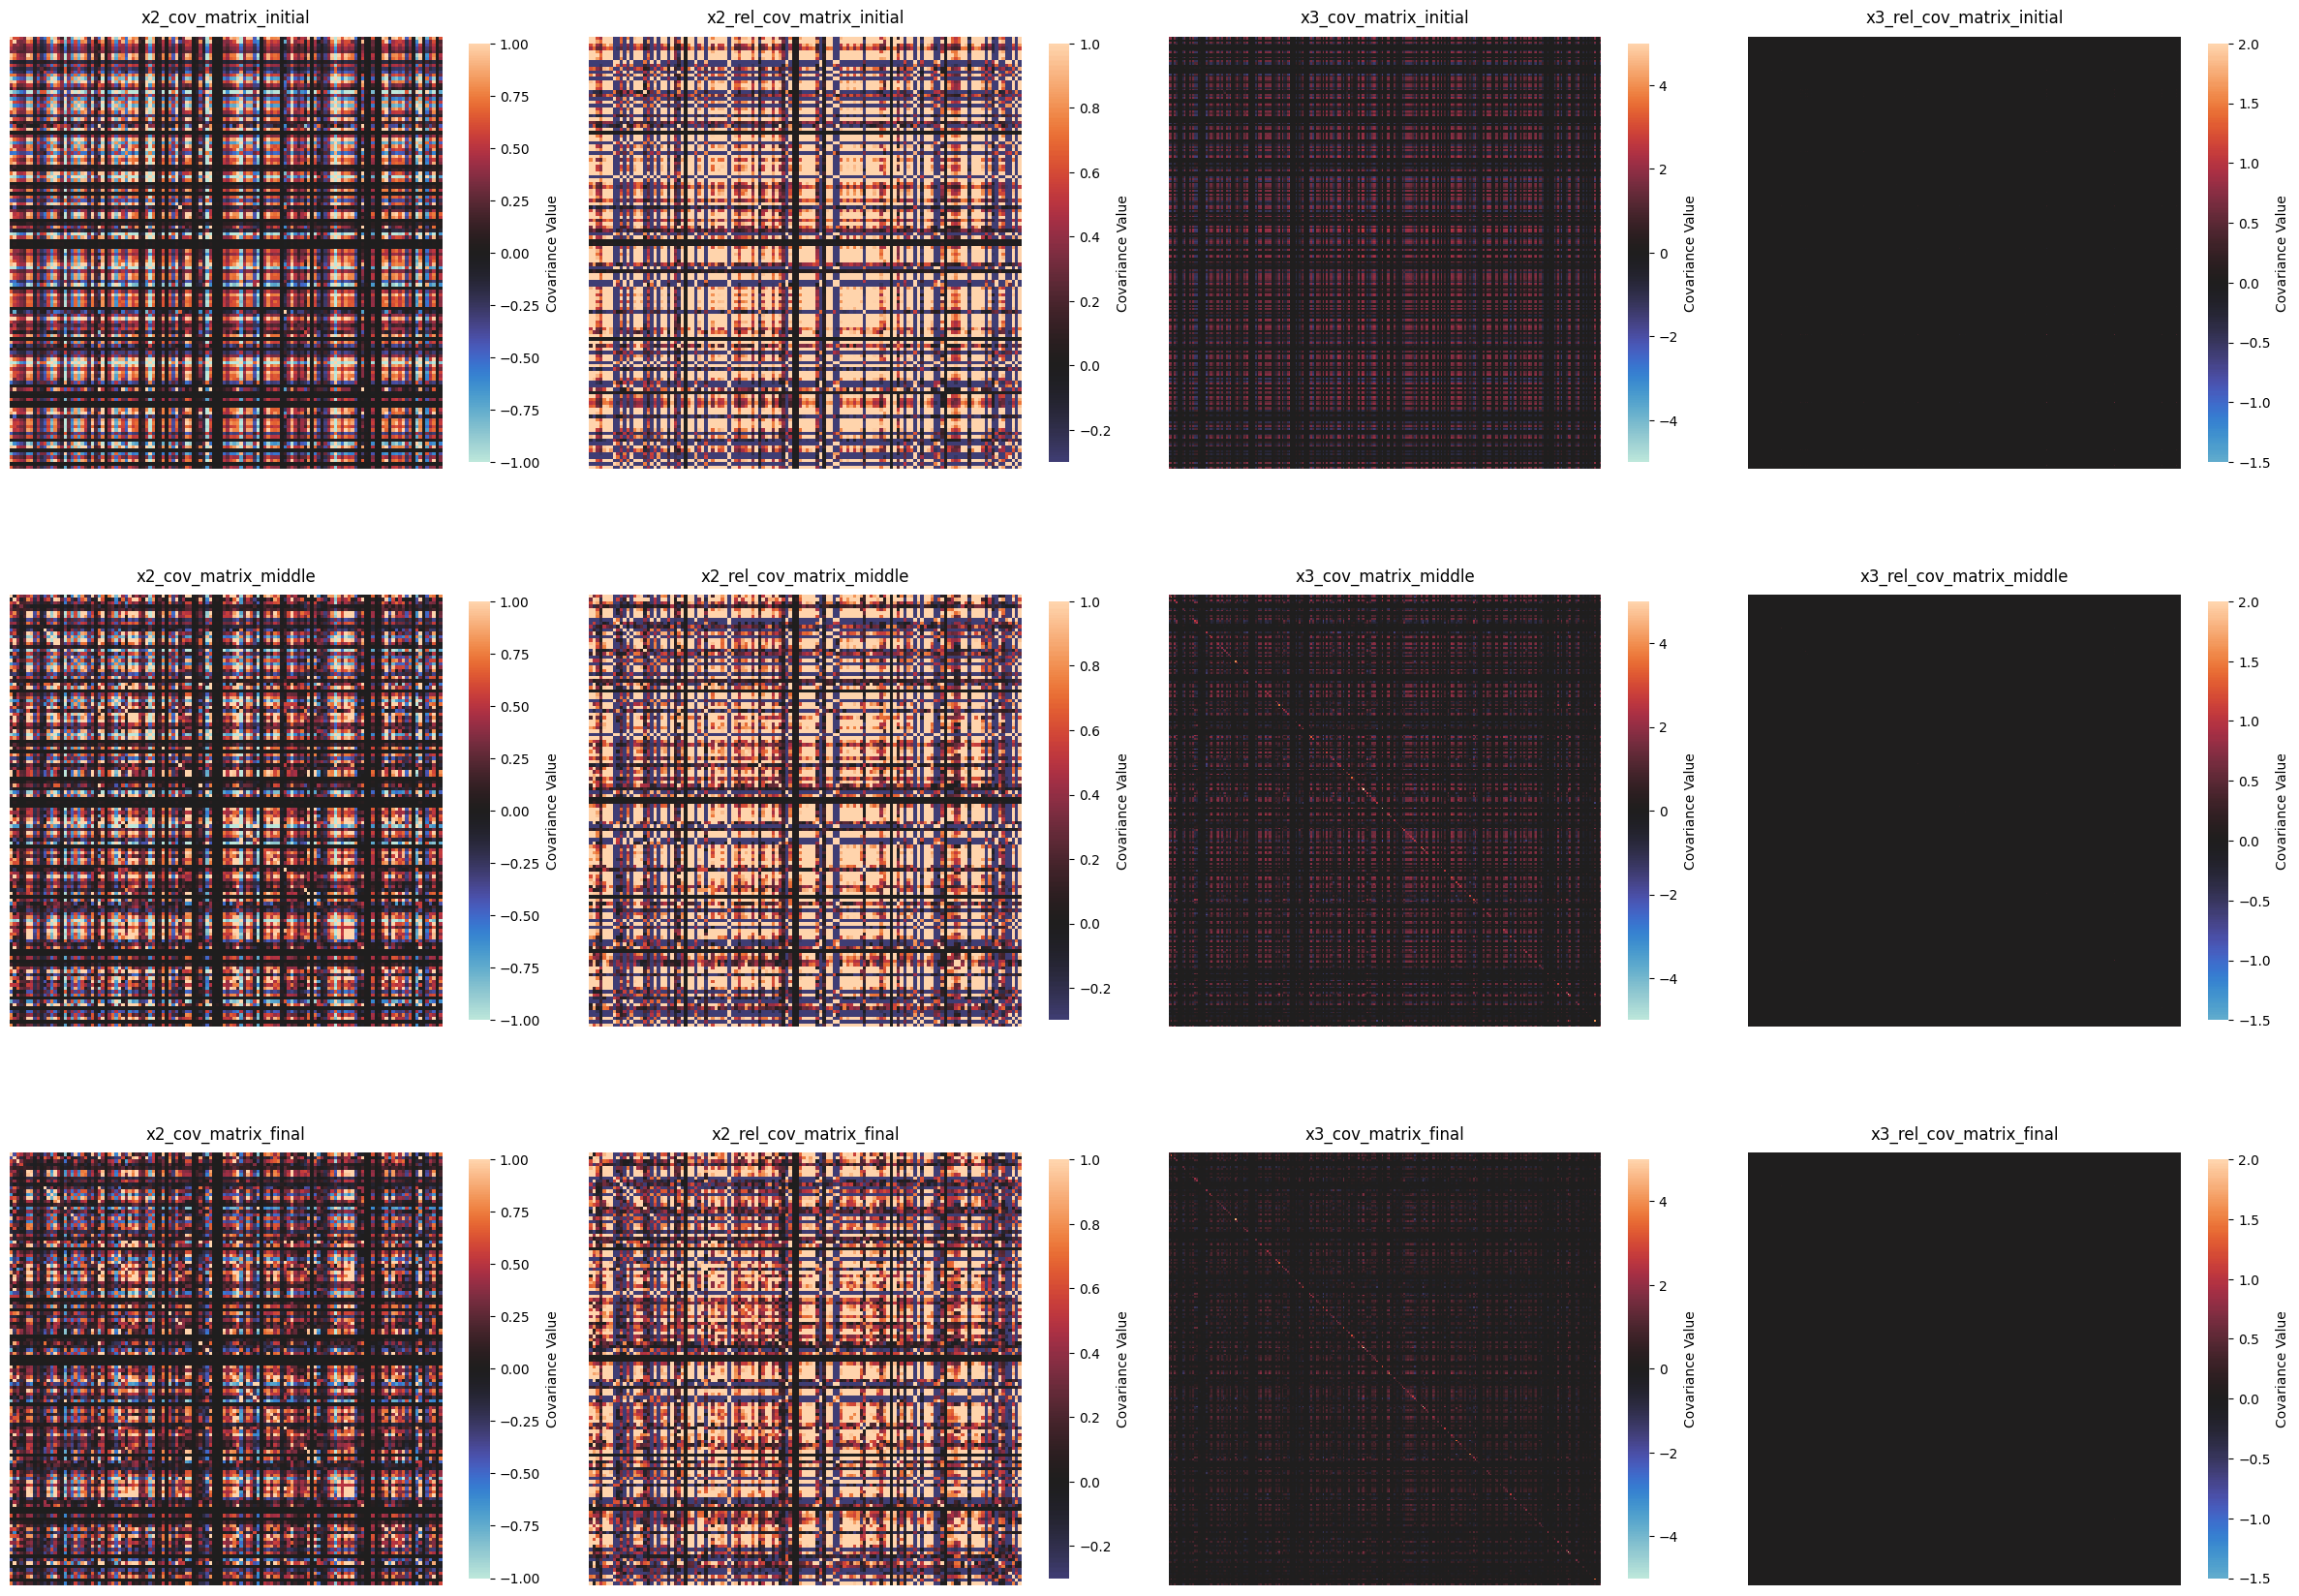

In [52]:
import os, io
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

def cov_to_corr(cov):
    std_dev = np.sqrt(np.clip(np.diag(cov), 1e-12, None))
    denom = np.outer(std_dev, std_dev)
    return cov / denom

def frob_offdiag(A: np.ndarray) -> float:
    A_off = A.copy()
    np.fill_diagonal(A_off, 0.0)     # zero the diagonal
    return np.linalg.norm(A_off, 'fro')

def _prep_tensor(x: torch.Tensor) -> torch.Tensor:
    """
    Flatten conv or linear activations into shape (N_samples, D_features).
    - Linear: already (N, D)
    - Conv: (N, C, H, W) -> (N*H*W, C)
    """
    if x.dim() == 2:        # linear layers: (N, D)
        return x
    elif x.dim() == 4:      # conv layers: (N, C, H, W)
        N, C, H, W = x.shape
        return x.permute(0, 2, 3, 1).reshape(-1, C)
    else:
        raise ValueError(f"Unsupported tensor shape {tuple(x.shape)}")

def cov_matrix(hidden_weights, save=False, save_dir="/scratch/tcrv4423/covariance"):
    cov_list = []
    length = len(hidden_weights)

    for i in range(length):
        print(f"Stage {i}...")

        # Concatenate batches along dim=0
        X2     = torch.cat(hidden_weights[i][0], dim=0).float()
        X2_rel = torch.cat(hidden_weights[i][1], dim=0).float()
        X3     = torch.cat(hidden_weights[i][2], dim=0).float()
        X3_rel = torch.cat(hidden_weights[i][3], dim=0).float()

        # Flatten if conv
        X2     = _prep_tensor(X2)
        X2_rel = _prep_tensor(X2_rel)
        X3     = _prep_tensor(X3)
        X3_rel = _prep_tensor(X3_rel)

        #print("Shapes after flatten:", X2.shape, X2_rel.shape, X3.shape, X3_rel.shape)

        def _cov(x):
            xc = x - x.mean(dim=0, keepdim=True)
            c = (xc.T @ xc) / max(x.shape[0] - 1, 1)
            return c.cpu().numpy()

        stage_name = ["initial", "middle", "final"][i] if i < 3 else f"stage_{i}"

        cov_list.extend([
            (_cov(X2),     f"x2_cov_matrix_{stage_name}"),
            (_cov(X2_rel), f"x2_rel_cov_matrix_{stage_name}"),
            (_cov(X3),     f"x3_cov_matrix_{stage_name}"),
            (_cov(X3_rel), f"x3_rel_cov_matrix_{stage_name}"),
        ])

    # Plot
    rows, cols = length, 4
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 6*rows))
    axes = axes.flatten()
    vmins = [-1, -0.3, -5, -1.5]
    vmaxs = [1, 1, 5, 2]

    for idx, (ax, (matrix, name)) in enumerate(zip(axes, cov_list)):
        frob = frob_offdiag(matrix)
        print(f"Frobenius norm of {file_path}: {frob:.6f}")
        c = idx % 4
        sns.heatmap(
            matrix,
            square=True,
            xticklabels=False,
            yticklabels=False,
            cmap="icefire",
            center=0,
            ax=ax,
            vmin=vmins[c],
            vmax=vmaxs[c],
            cbar_kws={'shrink': 0.7, 'label': 'Covariance Value'}
        )
        ax.set_title(name, pad=10)

        if save:
            os.makedirs(save_dir, exist_ok=True)
            features = [f"Feature_{i}" for i in range(matrix.shape[0])]
            df_cov = pd.DataFrame(matrix, index=features, columns=features)
            df_cov.to_excel(os.path.join(save_dir, f"{name}.xlsx"))

    plt.tight_layout()
    plt.show()

    return cov_list
print(len(hidden_weights)) 
matrix = cov_matrix(hidden_weights, False)
# corr = cov_to_corr(matrix)
# frob_corr = frob_offdiag(corr)
# print(frob_corr)

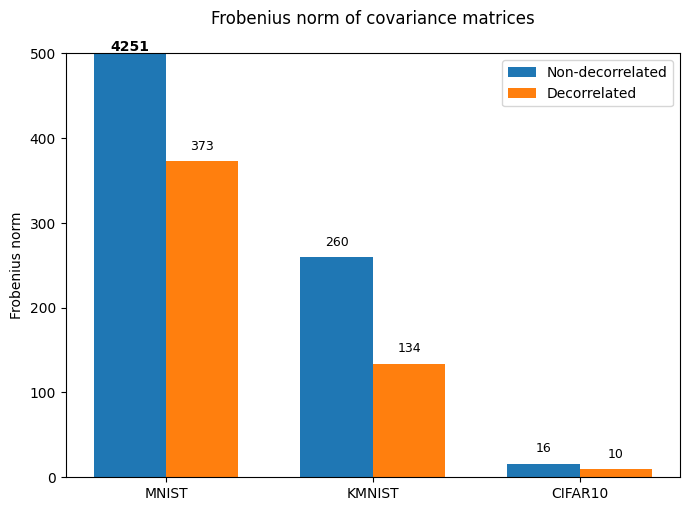

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
datasets = ["MNIST", "KMNIST", "CIFAR10"]
non_decorrelated = [4251, 260, 16]
decorrelated = [373, 134, 10]

x = np.arange(len(datasets))
width = 0.35

plt.figure(figsize=(7, 5))

# Bars
bars1 = plt.bar(x - width/2, non_decorrelated, width, label="Non-decorrelated")
bars2 = plt.bar(x + width/2, decorrelated, width, label="Decorrelated")

# Labels and title
plt.xticks(x, datasets)
plt.ylabel("Frobenius norm")
plt.title("Frobenius norm of covariance matrices")
plt.legend()

# Force y-axis to 0–500
plt.ylim(0, 500)

# Annotate bars with values
for bar, val in zip(bars1, non_decorrelated):
    if val > 500:
        # Place label at top of axis if bar is cut off
        plt.text(bar.get_x() + bar.get_width()/2, 500, f"{val}", 
                 ha='center', va='bottom', fontsize=10, color="black", weight="bold")
    else:
        plt.text(bar.get_x() + bar.get_width()/2, val + 10, f"{val}", 
                 ha='center', va='bottom', fontsize=9)

for bar, val in zip(bars2, decorrelated):
    plt.text(bar.get_x() + bar.get_width()/2, val + 10, f"{val}", 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.title("Frobenius norm of covariance matrices", y=1.05)
plt.show()


C:\Users\teowe\AppData\Local\Temp\ipykernel_11616\1877608052.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df.pivot_table(index=["Optimizer","Layer"], columns="Type", values="Value")


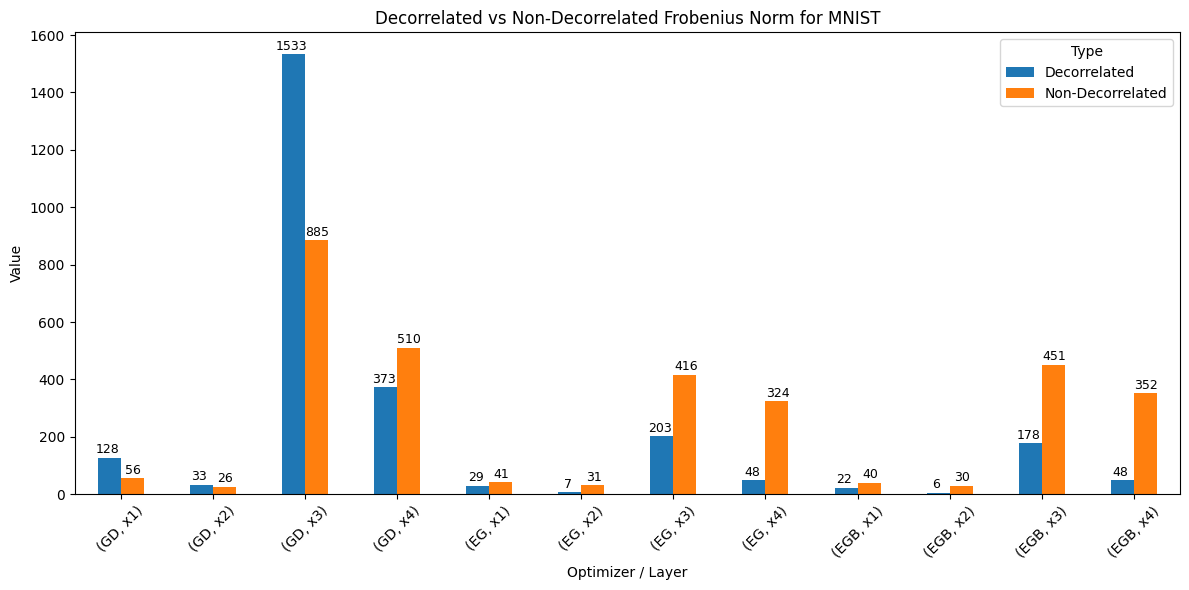

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Raw data
data = {
    "GD": {"x1": [128, 56], "x2": [33, 26], "x3": [1533, 885], "x4": [373, 510]},
    "EG": {"x1": [29, 41],  "x2": [7, 31],  "x3": [203, 416],  "x4": [48, 324]},
    "EGB":{"x1": [22, 40],  "x2": [6, 30],  "x3": [178, 451],  "x4": [48, 352]},
}

# Flatten into DataFrame
records = []
for optimizer, layers in data.items():
    for layer, (decor, cor) in layers.items():
        records.append([optimizer, layer, "Decorrelated", decor])
        records.append([optimizer, layer, "Non-Decorrelated", cor])

df = pd.DataFrame(records, columns=["Optimizer", "Layer", "Type", "Value"])

# Force optimizer order
order = ["GD", "EG", "EGB"]
df["Optimizer"] = pd.Categorical(df["Optimizer"], categories=order, ordered=True)

# Pivot for grouped bar plot
pivot_df = df.pivot_table(index=["Optimizer","Layer"], columns="Type", values="Value")

# Plot
ax = pivot_df.plot(kind="bar", figsize=(12,6))
plt.title("Decorrelated vs Non-Decorrelated Frobenius Norm for MNIST")
plt.ylabel("Value")
plt.xlabel("Optimizer / Layer")
plt.xticks(rotation=45)
plt.legend(title="Type")

# Offsets
x_offset_decor = -0.02
x_offset_cor   =  0.01

# Add labels separately for Decor and Cor
for container, label in zip(ax.containers, ["Decor", "Cor"]):
    for bar in container:
        height = bar.get_height()
        if label == "Decor":
            ax.text(
                bar.get_x() + bar.get_width()/2 + x_offset_decor,
                height + 5,
                f"{int(height)}",
                ha="center", va="bottom", fontsize=9
            )
        else:  # Cor
            ax.text(
                bar.get_x() + bar.get_width()/2 + x_offset_cor,
                height + 5,
                f"{int(height)}",
                ha="center", va="bottom", fontsize=9
            )

plt.tight_layout()
plt.show()


C:\Users\teowe\AppData\Local\Temp\ipykernel_11616\2261985422.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df.pivot_table(index=["Optimizer","Layer"], columns="Type", values="Value")


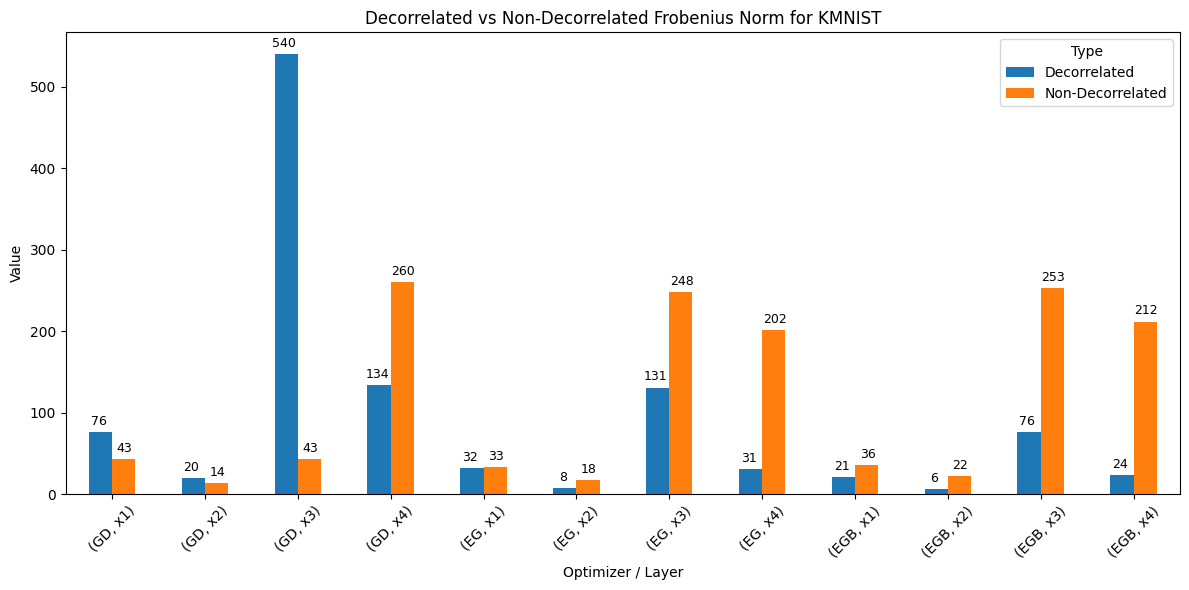

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Raw data
data = {
    "GD": {"x1": [76, 43], "x2": [20, 14], "x3": [540, 43], "x4": [134, 260]},
    "EG": {"x1": [32, 33],  "x2": [8, 18],  "x3": [131, 248],  "x4": [31, 202]},
    "EGB":{"x1": [21, 36],  "x2": [6, 22],  "x3": [76, 253],  "x4": [24, 212]},
}

# Flatten into DataFrame
records = []
for optimizer, layers in data.items():
    for layer, (decor, cor) in layers.items():
        records.append([optimizer, layer, "Decorrelated", decor])
        records.append([optimizer, layer, "Non-Decorrelated", cor])

df = pd.DataFrame(records, columns=["Optimizer", "Layer", "Type", "Value"])

# Force optimizer order
order = ["GD", "EG", "EGB"]
df["Optimizer"] = pd.Categorical(df["Optimizer"], categories=order, ordered=True)

# Pivot for grouped bar plot
pivot_df = df.pivot_table(index=["Optimizer","Layer"], columns="Type", values="Value")

# Plot
ax = pivot_df.plot(kind="bar", figsize=(12,6))
plt.title("Decorrelated vs Non-Decorrelated Frobenius Norm for KMNIST")
plt.ylabel("Value")
plt.xlabel("Optimizer / Layer")
plt.xticks(rotation=45)
plt.legend(title="Type")

# Offsets
x_offset_decor = -0.02
x_offset_cor   =  0.01

# Add labels separately for Decor and Cor
for container, label in zip(ax.containers, ["Decor", "Cor"]):
    for bar in container:
        height = bar.get_height()
        if label == "Decor":
            ax.text(
                bar.get_x() + bar.get_width()/2 + x_offset_decor,
                height + 5,
                f"{int(height)}",
                ha="center", va="bottom", fontsize=9
            )
        else:  # Cor
            ax.text(
                bar.get_x() + bar.get_width()/2 + x_offset_cor,
                height + 5,
                f"{int(height)}",
                ha="center", va="bottom", fontsize=9
            )

plt.tight_layout()
plt.show()


C:\Users\teowe\AppData\Local\Temp\ipykernel_11616\3548563394.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df.pivot_table(index=["Optimizer","Layer"], columns="Type", values="Value")


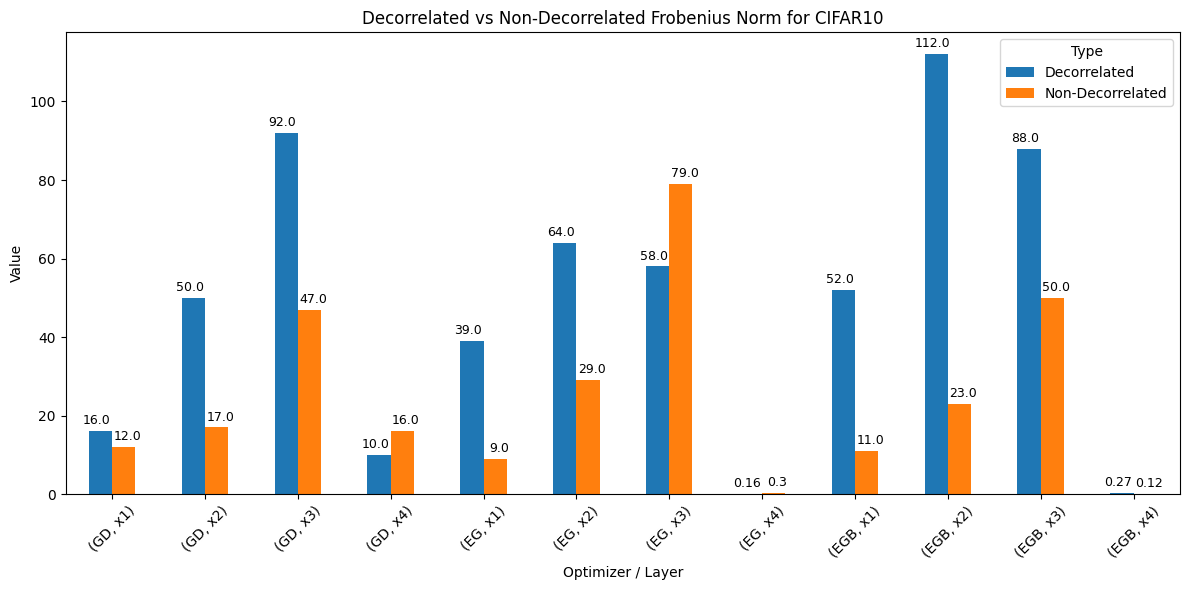

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Raw data
data = {
    "GD": {"x1": [16, 12], "x2": [50, 17], "x3": [92, 47], "x4": [10, 16]},
    "EG": {"x1": [39, 9],  "x2": [64, 29],  "x3": [58, 79],  "x4": [0.16, 0.3]},
    "EGB":{"x1": [52, 11],  "x2": [112, 23],  "x3": [88, 50],  "x4": [0.27, 0.12]},
}

# Flatten into DataFrame
records = []
for optimizer, layers in data.items():
    for layer, (decor, cor) in layers.items():
        records.append([optimizer, layer, "Decorrelated", decor])
        records.append([optimizer, layer, "Non-Decorrelated", cor])

df = pd.DataFrame(records, columns=["Optimizer", "Layer", "Type", "Value"])

# Force optimizer order
order = ["GD", "EG", "EGB"]
df["Optimizer"] = pd.Categorical(df["Optimizer"], categories=order, ordered=True)

# Pivot for grouped bar plot
pivot_df = df.pivot_table(index=["Optimizer","Layer"], columns="Type", values="Value")

# Plot
ax = pivot_df.plot(kind="bar", figsize=(12,6))
plt.title("Decorrelated vs Non-Decorrelated Frobenius Norm for CIFAR10")
plt.ylabel("Value")
plt.xlabel("Optimizer / Layer")
plt.xticks(rotation=45)
plt.legend(title="Type")

# Offsets
x_offset_decor = -0.04
x_offset_cor   =  0.04

# Add labels separately for Decor and Cor
for container, label in zip(ax.containers, ["Decor", "Cor"]):
    for bar in container:
        height = bar.get_height()
        if label == "Decor":
            ax.text(
                bar.get_x() + bar.get_width()/2 + x_offset_decor,
                height + 1,
                f"{(height)}",
                ha="center", va="bottom", fontsize=9
            )
        else:  # Cor
            ax.text(
                bar.get_x() + bar.get_width()/2 + x_offset_cor,
                height + 1,
                f"{(height)}",
                ha="center", va="bottom", fontsize=9
            )

plt.tight_layout()
plt.show()
